# N-Player Shaping plots

In [2]:
# !pip install seaborn
import wandb
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
sns.set_theme(style="white", palette='colorblind')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
def vmap_smooth(scalars: np.array, weight: float):  # Weight between 0 and 1
    last = scalars[..., 0]  # First value in the plot (first timestep)
    smoothed = list()
    for i in range(scalars.shape[-1]):
        smoothed_val = last * weight + (1 - weight) * scalars[..., i]  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return np.stack(smoothed, axis=-1)

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [4]:
api = wandb.Api(timeout=19)

In [5]:
# globals: path, ylims, game_name
# path = '/Users/timonwilli/Documents/nshaper_figs/'
path = 'nshaper_figs/'
ylims = {'sd_3':(0,3), 'sd_4':(0,4), 'sd_5':(0,5), 'sh_3':(-3,4), 'sh_4':(-3,4.5), 'sh_5':(-3,4.8), 'tc_3':(-3,5), 'tc_4':(-3,5), 'tc_5':(-3,5), 'ipd_3':(0,5), 'ipd_4':(0,7), 'ipd_5':(0,9)}
game_name = {'sd': 'Snowdrift', 'ipd': 'Prisoner\'s Dilemma', 'sh': 'Stag Hunt', 'tc': 'Tragedy of the Commons'}


def plot_naive_rewards(game,num_pl,smooth_factor=0.99):
    runs = api.runs(path="ucl-dark/tensor",
     filters={"config.wandb.group": f"naive_{num_pl}pl_{game}"})
    plt.figure()
    rewards_dict = {pl_idx: [] for pl_idx in range(num_pl)}
    xs = []

    for run in runs:
        rew_keys = [f'train/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_pl)]
        df = run.scan_history(keys=rew_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        for pl_idx in range(num_pl):
            rewards_dict[pl_idx].append([row[f'train/reward_per_timestep/player_{pl_idx+1}'] for row in df])
    _xs = np.array(xs)
    smooth_rewards_dict = {pl_idx: vmap_smooth(np.array(rewards_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl)}


    x = _xs[0, :]
    medians = {pl_idx: np.median(smooth_rewards_dict[pl_idx], axis=0) for pl_idx in range(num_pl)}
    stds = {pl_idx: np.std(smooth_rewards_dict[pl_idx], axis=0) for pl_idx in range(num_pl)}

    for pl_idx in range(num_pl):
        plt.plot(x, medians[pl_idx], label=f"NL {pl_idx+1}")
        plt.fill_between(x, medians[pl_idx]-stds[pl_idx], medians[pl_idx]+stds[pl_idx], alpha=0.2)

    plt.legend(fontsize=15)
    # plt.xlim(0, 1250) # hmm
    plt.ylim(ylims[f'{game}_{num_pl}'][0]-0.2, ylims[f'{game}_{num_pl}'][1]+0.2)

    plt.xlabel("Episode", fontsize=15)
    plt.ylabel("Reward Per Timestep", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{game_name[game]} with {num_pl} Naive PPO Memory agents", fontsize=20)

    os.makedirs(path+f"{game}/{num_pl}_pl/eval/", exist_ok=True)
    plt.savefig(path+f"{game}/{num_pl}_pl/eval/naive_rewards.png", bbox_inches='tight')
    return plt

In [6]:
def plot_shaper_rewards(game,num_pl,num_shap,training_or_eval,smooth_factor=0,flip_dict =None,crop_to_shortest=False, only_seeds=None):
    if training_or_eval == 'training':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}"}, {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}"}]}
    elif training_or_eval == 'eval':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}-eval"},{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}_eval"},  {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}-eval"}]}
    else:
        raise ValueError("training_or_eval must be 'training' or 'eval'")
    runs = api.runs(path=f"ucl-dark/tensor-{game}",
     filters=group_filter)
    plt.figure()
    target_dict = {pl_idx: [] for pl_idx in range(num_pl-num_shap)}
    shaper_dict = {pl_idx: [] for pl_idx in range(num_shap)}
    xs = []

    tag = "train" if training_or_eval == 'training' else "eval"
    for run in runs:
        current_seed = run.config["seed"] if tag=="train" else int(run.name.split("-eval")[0][-1]) #evals end w/ seed-eval
        int(current_seed) # make sure it's an int
        if only_seeds is not None and current_seed not in only_seeds:
            continue
        if f'{tag}/reward_per_timestep/target_1' in run.history():
            target_keys = [f'{tag}/reward_per_timestep/target_{pl_idx+1}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/shaper_{pl_idx+1}' for pl_idx in range(num_shap)]
        else:
            target_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1+num_shap}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_shap)]
        df = run.scan_history(keys=target_keys+shaper_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        if not flip_dict or current_seed not in flip_dict.keys():
            for pl_idx,target_key in zip(range(num_pl-num_shap),target_keys):
                target_dict[pl_idx].append([row[target_key] for row in df])
            for pl_idx,shaper_key in zip(range(num_shap), shaper_keys):
                shaper_dict[pl_idx].append([row[shaper_key] for row in df])
        else:
            flips = flip_dict[current_seed]
            for pl_idx,target_key in zip(range(num_pl-num_shap),target_keys):
                target_dict[flips[pl_idx+num_shap]-num_shap].append([row[target_key] for row in df])

            for pl_idx,shaper_key in zip(range(num_shap), shaper_keys):
                shaper_dict[flips[pl_idx]].append([row[shaper_key] for row in df])
    if crop_to_shortest:
        min_len = min([len(x) for x in xs])
        xs = [x[:min_len] for x in xs]
        for pl_idx in range(num_pl-num_shap):
            target_dict[pl_idx] = [x[:min_len] for x in target_dict[pl_idx]]
        for pl_idx in range(num_shap):
            shaper_dict[pl_idx] = [x[:min_len] for x in shaper_dict[pl_idx]]
    _xs = np.array(xs)
    smooth_target_dict = {pl_idx: vmap_smooth(np.array(target_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl-num_shap)}
    smooth_shaper_dict = {pl_idx:  vmap_smooth(np.array(shaper_dict[pl_idx]),smooth_factor) for pl_idx in range(num_shap)}


    x = _xs[0, :]
    median_targets = {pl_idx: np.median(smooth_target_dict[pl_idx], axis=0) for pl_idx in range(num_pl-num_shap)}
    median_shapers = {pl_idx: np.median(smooth_shaper_dict[pl_idx], axis=0) for pl_idx in range(num_shap)}

    std_targets = {pl_idx: np.std(smooth_target_dict[pl_idx], axis=0) for pl_idx in range(num_pl-num_shap)}
    std_shapers = {pl_idx: np.std(smooth_shaper_dict[pl_idx], axis=0) for pl_idx in range(num_shap)}

    line_style_dict = {0: '-', 1: '--', 2: '-.', 3: ':'}
    for pl_idx in range(num_pl-num_shap):
        plt.plot(x, median_targets[pl_idx], label=f"NL {pl_idx+1}", linestyle=line_style_dict[pl_idx])
        plt.fill_between(x, median_targets[pl_idx]-std_targets[pl_idx], median_targets[pl_idx]+std_targets[pl_idx], alpha=0.3)
    for pl_idx in range(num_shap):
        plt.plot(x, median_shapers[pl_idx], label=f"Shaper {pl_idx+1}", linestyle=line_style_dict[pl_idx])
        plt.fill_between(x, median_shapers[pl_idx]-std_shapers[pl_idx], median_shapers[pl_idx]+std_shapers[pl_idx], alpha=0.3)


    plt.legend(fontsize=15)
    # plt.xlim(0, 1250) # hmm
    plt.ylim(ylims[f'{game}_{num_pl}'][0]-0.2, ylims[f'{game}_{num_pl}'][1]+0.2)

    plt.xlabel("Episode", fontsize=15)
    plt.ylabel("Reward Per Timestep", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{game_name[game]} with {num_shap} Shaper vs {num_pl-num_shap} Naive PPO Memory agents, {training_or_eval}", fontsize=20)

    os.makedirs(path+f"{game}/{num_pl}_pl/{training_or_eval}/", exist_ok=True)
    if only_seeds is None:
        plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_rewards.png", bbox_inches='tight')
    else:
        seeds ="_".join([str(seed) for seed in only_seeds])
        plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_rewards_seed{seeds}.png", bbox_inches='tight')

    return plt

In [7]:
import itertools


def plot_naive_states(game,num_pl,smooth_factor=0,flip_dict =None,crop_to_shortest=False, only_seeds=None, legend=None):
    runs = api.runs(path="ucl-dark/tensor",
     filters={"config.wandb.group": f"naive_{num_pl}pl_{game}"})
    plt.figure()
    xs = []

    # get string of all possible states: CCC, CCD, CDC, DDD, etc.
    states = ["".join(x) for x in itertools.product("CD", repeat=num_pl)]
    state_dict = {state: [] for state in states}
    for run in runs:
        state_keys = [f'state_probability/{state}' for state in states]
        df = run.scan_history(keys=state_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        for state,state_key in zip(states, state_keys):
            state_dict[state].append([row[state_key] for row in df])
    if crop_to_shortest:
        min_len = min([len(x) for x in xs])
        xs = [x[:min_len] for x in xs]
        for state in state_dict.keys():
            state_dict[state] = [x[:min_len] for x in state_dict[state]]
    _xs = np.array(xs)

    group_state_dict = {}
    for state in state_dict.keys():
        num_d = state.count("D")
        if num_d not in group_state_dict.keys():
            group_state_dict[num_d] = np.array(state_dict[state])
        else:
            group_state_dict[num_d] += np.array(state_dict[state])

    smooth_state_dict = {state: vmap_smooth(np.array(group_state_dict[state]), smooth_factor) for state in group_state_dict.keys()}


    x = _xs[0, :]
    median_states = {state: np.median(smooth_state_dict[state], axis=0) for state in group_state_dict.keys()}
    std_states = {state: np.std(smooth_state_dict[state], axis=0) for state in group_state_dict.keys()}

    for state in group_state_dict.keys():
        if legend and state in legend:
            legend_label = f"{state}D, {num_pl-state}C"
            plt.plot(x, median_states[state], label=legend_label)
        elif legend and state not in legend:
            plt.plot(x, median_states[state])
        elif not legend:
            plt.plot(x, median_states[state], label = f"{state}D, {num_pl-state}C")
        plt.fill_between(x, median_states[state]-std_states[state], median_states[state]+std_states[state], alpha=0.3)

    plt.legend(fontsize=15)
    # plt.xlim(0, 1250) # hmm
    plt.ylim(0, 1)

    plt.xlabel("Episode", fontsize=15)
    plt.ylabel("State distribution", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{game_name[game]} with {num_pl} Naive PPO Memory agents", fontsize=20)

    os.makedirs(path+f"{game}/{num_pl}_pl/eval/", exist_ok=True)
    plt.savefig(path+f"{game}/{num_pl}_pl/eval/naive_states_png", bbox_inches='tight')

    return plt

In [8]:
import itertools


def plot_3pl_states(game,num_pl,num_shap,training_or_eval,smooth_factor=0,flip_dict =None,crop_to_shortest=False, only_seeds=None, legend=None, grouped=False):
    if training_or_eval == 'training':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}"}, {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}"}]}
    elif training_or_eval == 'eval':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}-eval"},{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}_eval"},  {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}-eval"}]}
    else:
        raise ValueError("training_or_eval must be 'training' or 'eval'")
    runs = api.runs(path=f"ucl-dark/tensor-{game}",
     filters=group_filter)
    plt.figure()
    xs = []

    # get string of all possible states: CCC, CCD, CDC, DDD, etc.
    states = ["".join(x) for x in itertools.product("CD", repeat=num_pl)]
    state_dict = {state: [] for state in states}
    tag = "train" if training_or_eval == 'training' else "eval"
    for run in runs:
        current_seed = run.config["seed"] if tag=="train" else int(run.name.split("-eval")[0][-1]) #evals end w/ seed-eval
        int(current_seed) # make sure it's an int
        if only_seeds is not None and current_seed not in only_seeds:
            continue
        state_keys = [f'state_probability/{state}' for state in states]
        df = run.scan_history(keys=state_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        if not flip_dict or current_seed not in flip_dict.keys():
            for state,state_key in zip(states, state_keys):
                state_dict[state].append([row[state_key] for row in df])
        else:
            flips = flip_dict[current_seed]
            raise NotImplementedError("Need to implement flipping")
            for state,state_key in zip(states, state_keys):
                new_state = None
                state_dict[new_state].append([row[state_keys] for row in df])
    if crop_to_shortest:
        min_len = min([len(x) for x in xs])
        xs = [x[:min_len] for x in xs]
        for state in state_dict.keys():
            state_dict[state] = [x[:min_len] for x in state_dict[state]]
    _xs = np.array(xs)


    if grouped == True:
        grouped_state_dict = {}
        for state in state_dict.keys():
            # (num shapers D, num targets D)
            defects =  (state[:num_shap].count("D"), state[num_shap:].count("D"))
            if defects not in grouped_state_dict.keys():
                grouped_state_dict[defects] = np.array(state_dict[state], dtype=np.float64)
            else:
                grouped_state_dict[defects] += np.array(state_dict[state], dtype=np.float64)
        smooth_state_dict = {state: vmap_smooth(np.array(grouped_state_dict[state]), smooth_factor) for state in grouped_state_dict.keys()}
    else:
        smooth_state_dict = {state: vmap_smooth(np.array(state_dict[state]), smooth_factor) for state in state_dict.keys()}


    x = _xs[0, :]
    median_states = {state: np.median(smooth_state_dict[state], axis=0) for state in smooth_state_dict.keys()}
    std_states = {state: np.std(smooth_state_dict[state], axis=0) for state in smooth_state_dict.keys()}

    for state in smooth_state_dict.keys():
        if legend and state in legend:
            if not grouped:
                legend_label = f"{state[:num_shap]}, {state[num_shap:]}"
            else:
                if num_shap == 1:
                    shap_str = f"shaper {'D' if state[0]==1 else 'C'}"
                else :
                    shap_str = f"shapers {state[0]}D{num_shap-state[0]}C"
                if num_pl-num_shap == 1:
                    target_str = f"NLs {'D' if state[1]==1 else 'C'}"
                else:
                    target_str = f"NLs {state[1]}D{num_pl-num_shap-state[1]}C"
                legend_label = f"{shap_str}, {target_str}"
            plt.plot(x, median_states[state], label=legend_label)
        elif legend and state not in legend:
            plt.plot(x, median_states[state])
        elif not legend:
            plt.plot(x, median_states[state], label=state)
        plt.fill_between(x, median_states[state]-std_states[state], median_states[state]+std_states[state], alpha=0.3)

    plt.legend(fontsize=15)
    # plt.xlim(0, 1250) # hmm
    plt.ylim(0, 1)

    plt.xlabel("Episode", fontsize=15)
    plt.ylabel("State distribution", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(f"{game_name[game]} with {num_shap} Shaper vs {num_pl-num_shap} Naive PPO Memory agents, {training_or_eval}", fontsize=20)

    os.makedirs(path+f"{game}/{num_pl}_pl/{training_or_eval}/", exist_ok=True)
    if only_seeds is None:
        plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_states.png", bbox_inches='tight')
    else:
        seeds ="_".join([str(seed) for seed in only_seeds])
        plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_states_seed{seeds}.png", bbox_inches='tight')

    return plt

## SD 3pl

### Naive

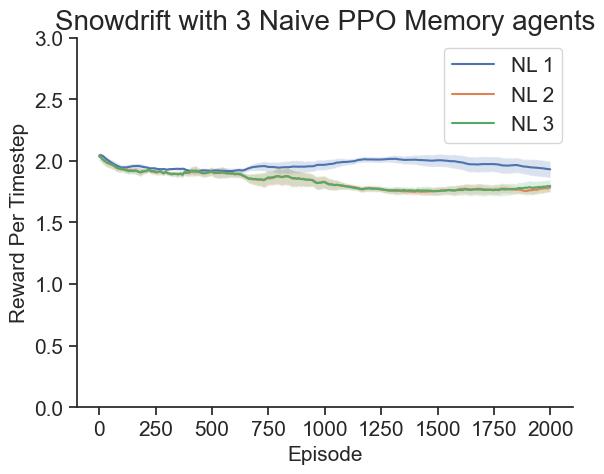

In [6]:
plot_naive_rewards("sd",3).show()

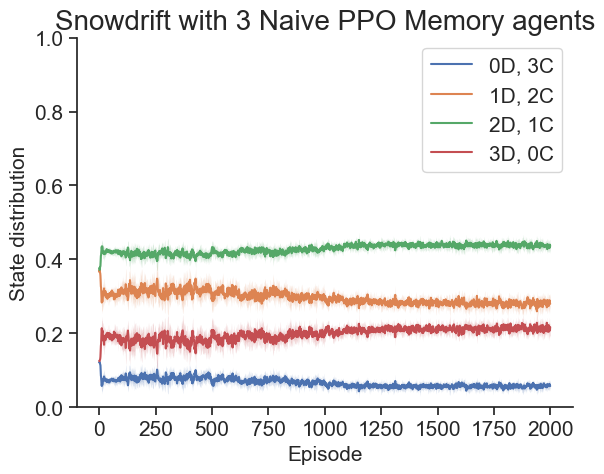

In [87]:
plot_naive_states("sd",3,).show()

### 1 shaper

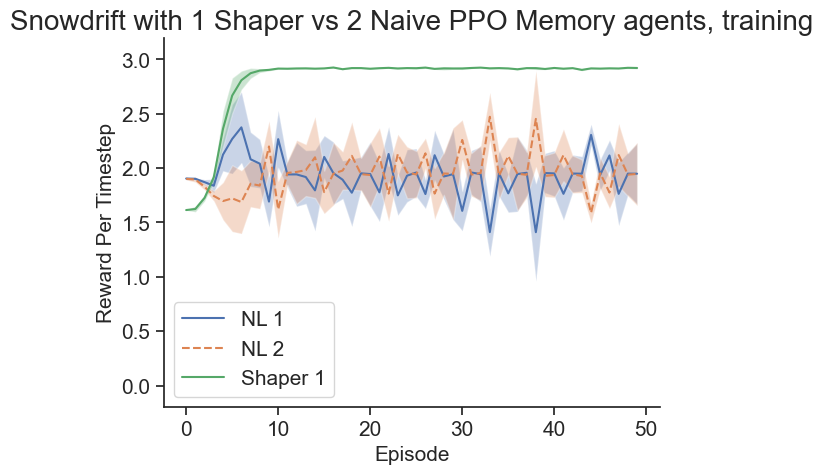

In [78]:
plot_shaper_rewards("sd",3,1,'training', smooth_factor=0).show()


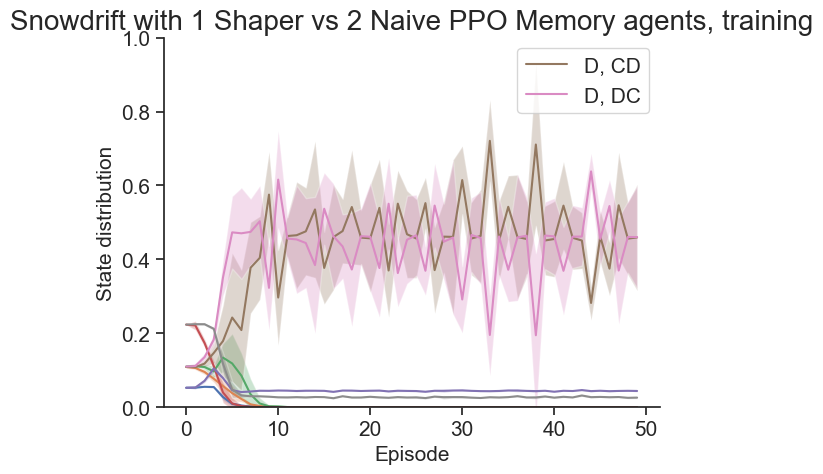

In [44]:
plot_3pl_states("sd",3,1,'training', smooth_factor=0, legend=["DCD", "DDC"]).show()


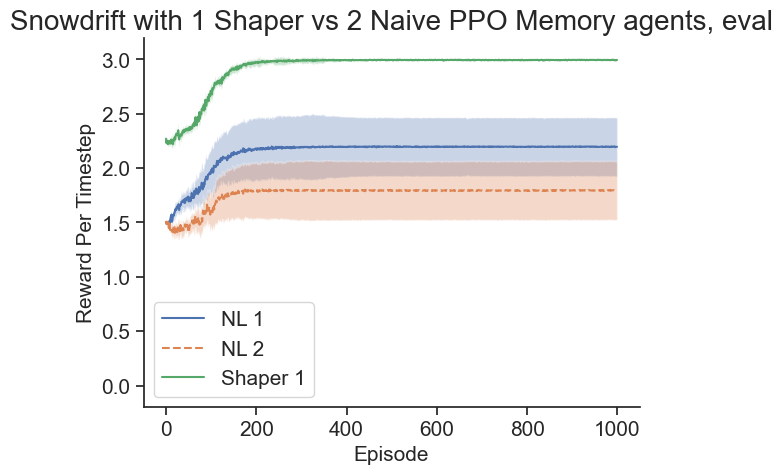

In [79]:
plot_shaper_rewards("sd",3,1,'eval', smooth_factor=0).show()

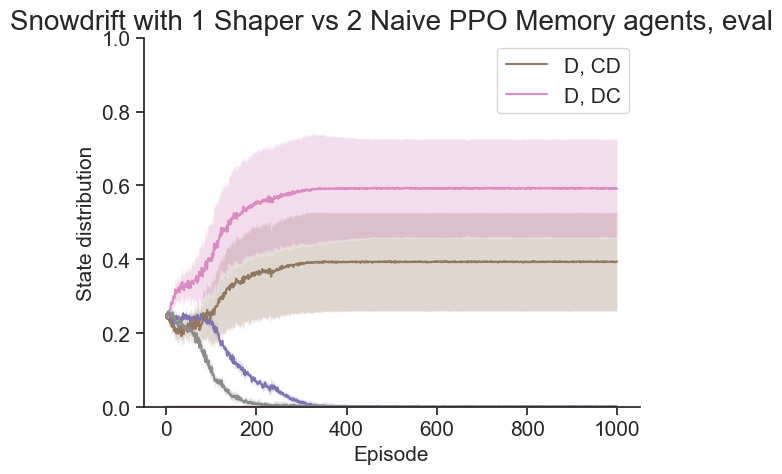

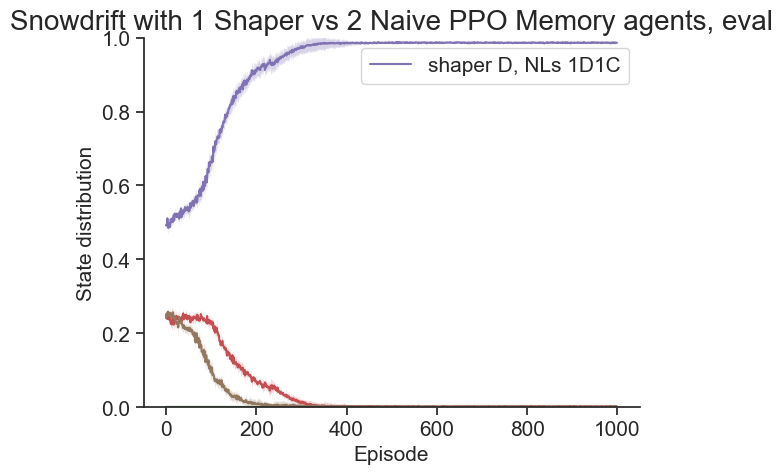

In [86]:
plot_3pl_states("sd",3,1,'eval', smooth_factor=0, legend=["DCD", "DDC"]).show()
plot_3pl_states("sd",3,1,'eval', smooth_factor=0, legend=[(1,1)], grouped=True).show()


### 2 shaper

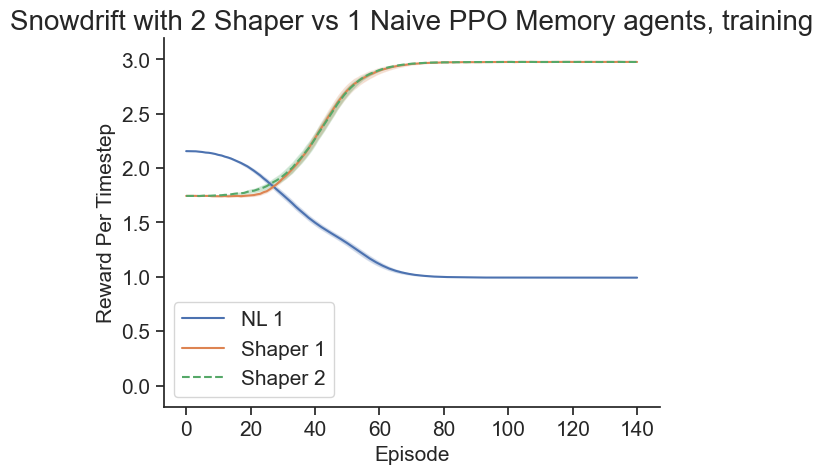

In [80]:
plot_shaper_rewards("sd",3,2,'training', crop_to_shortest=True, smooth_factor=0).show()

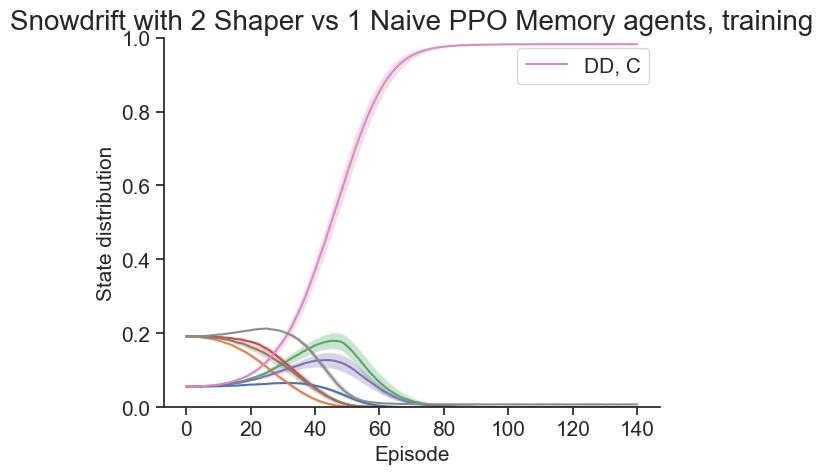

In [46]:
plot_3pl_states("sd",3,2,'training', smooth_factor=0,  crop_to_shortest=True, legend=["DDC"]).show()

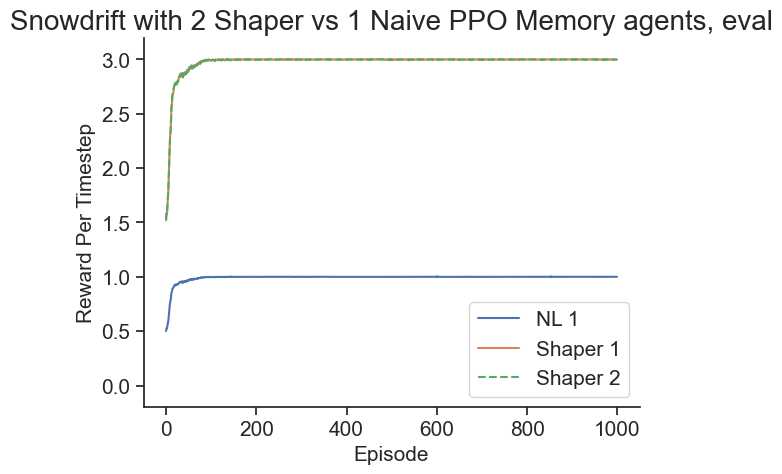

In [81]:
plot_shaper_rewards("sd",3,2,'eval', smooth_factor=0).show()

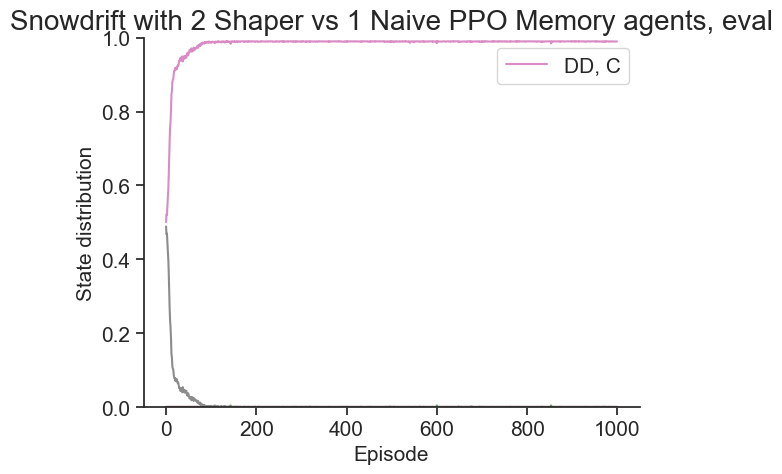

In [58]:
plot_3pl_states("sd",3,2,'eval', smooth_factor=0, legend=["DDC"]).show()

## SD 4pl

### Naive

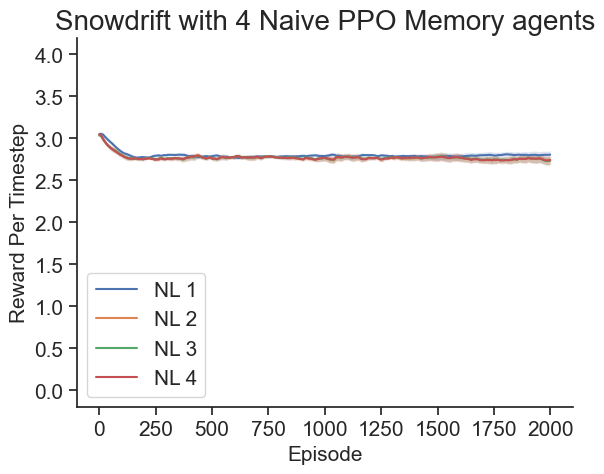

In [88]:
plot_naive_rewards("sd",4).show()

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


<module 'matplotlib.pyplot' from '/Users/alexandrasouly/miniconda3/envs/pax/lib/python3.9/site-packages/matplotlib/pyplot.py'>

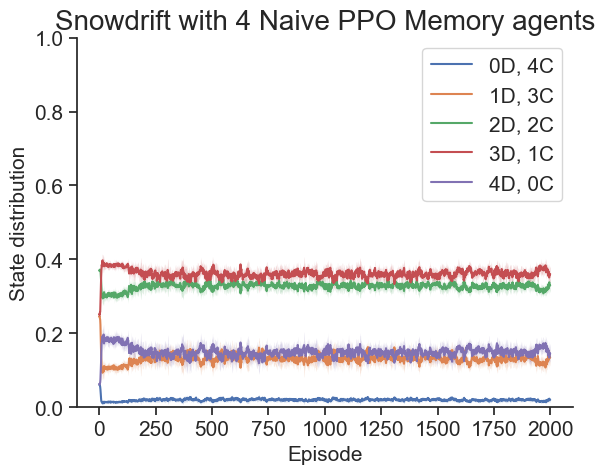

In [89]:
plot_naive_states("sd",4)

### 1 shaper - seeds diverged
seed 1 and 5 achieves perfect score for 3 out of 4 players!  
seed 2,3,4 gets all the NLs equally exploited

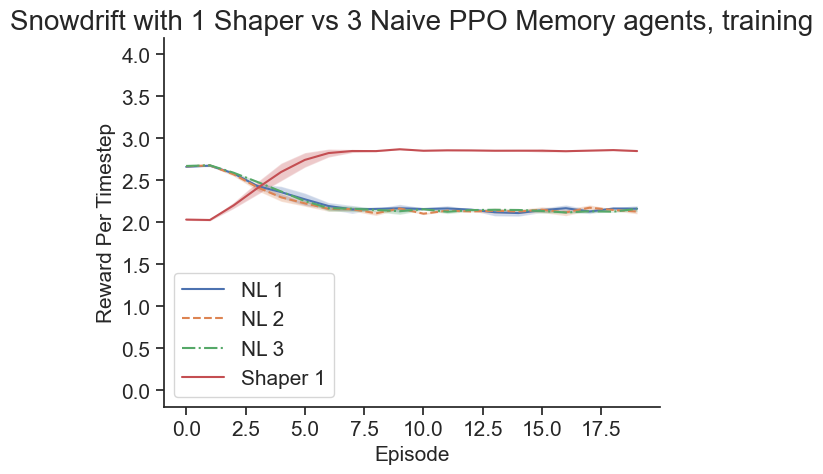

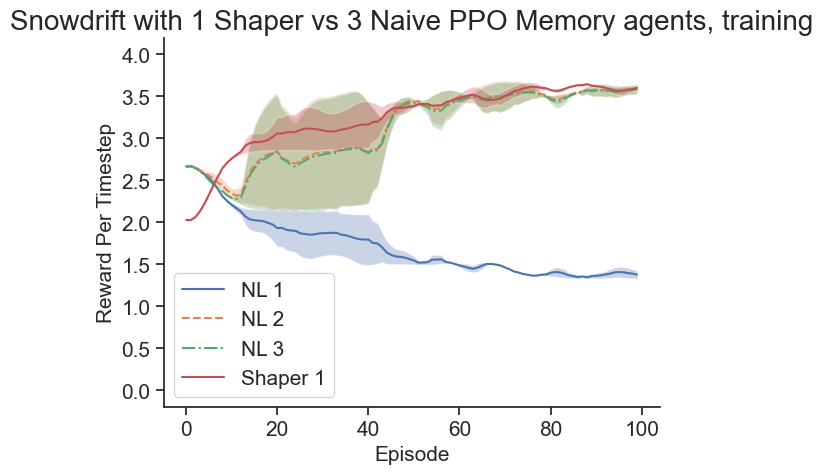

In [87]:
plot_shaper_rewards("sd",4,1,'training', only_seeds=[2,3,4], smooth_factor=0).show()
plot_shaper_rewards("sd",4,1,'training', only_seeds=[1,5], smooth_factor=0.7).show()

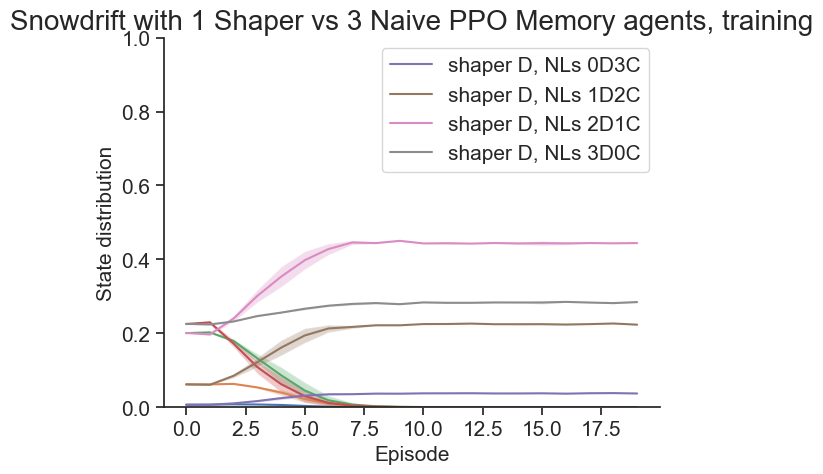

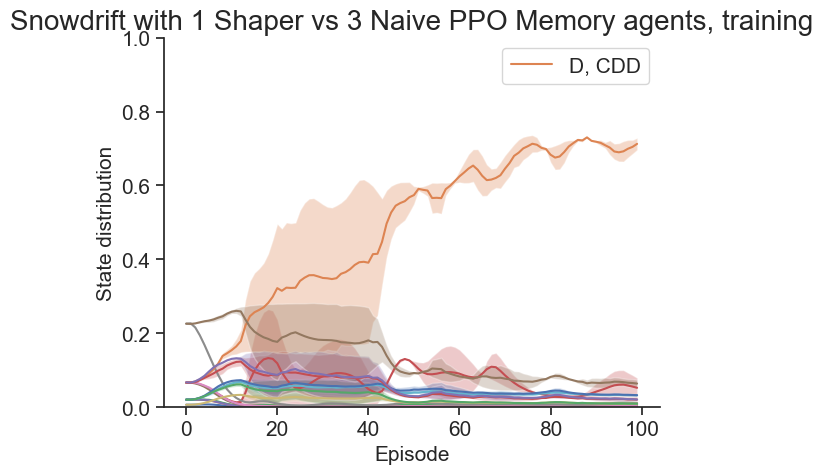

In [90]:
plot_3pl_states("sd",4,1,'training', only_seeds=[2,3,4], smooth_factor=0, grouped= True, legend=[(1,3),(1,2),(1,1), (1,0)]).show()
plot_3pl_states("sd",4,1,'training', only_seeds=[1,5], smooth_factor=0.7, legend=['DCDD']).show()

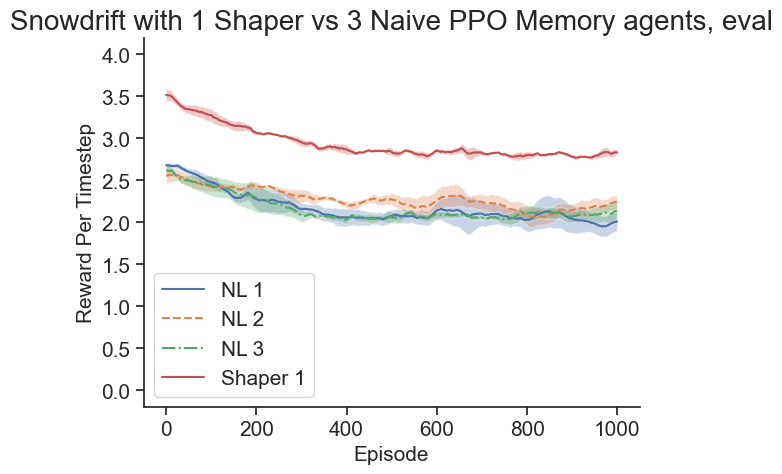

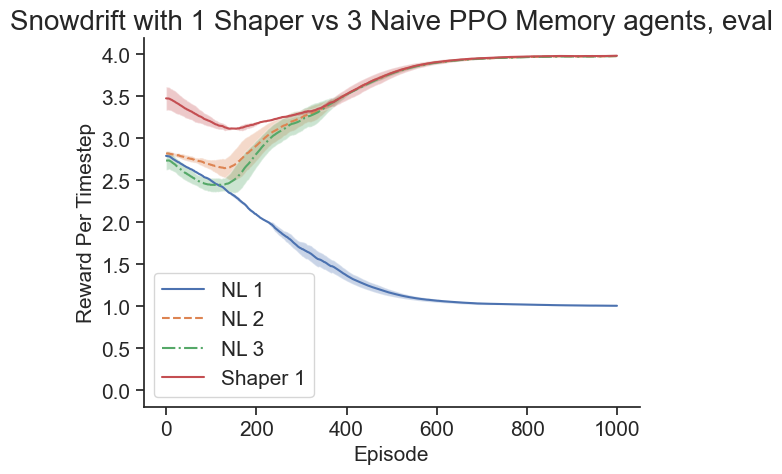

In [89]:
plot_shaper_rewards("sd",4,1,'eval', only_seeds=[2,3,4], smooth_factor=0.99).show()
plot_shaper_rewards("sd",4,1,'eval', only_seeds=[1,5], smooth_factor=0.99).show()

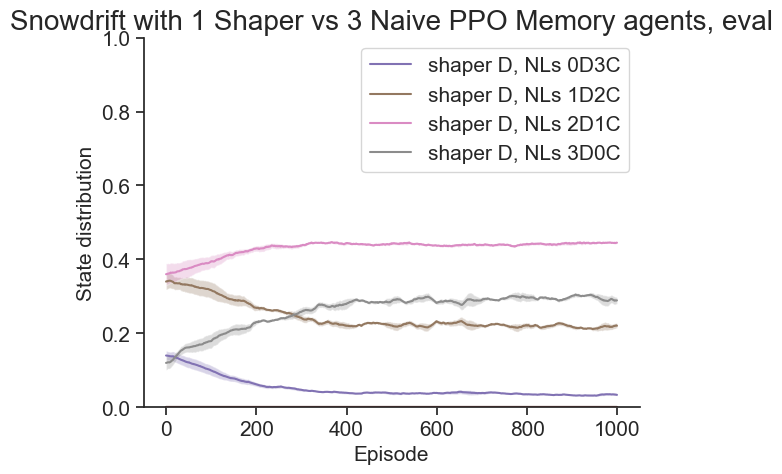

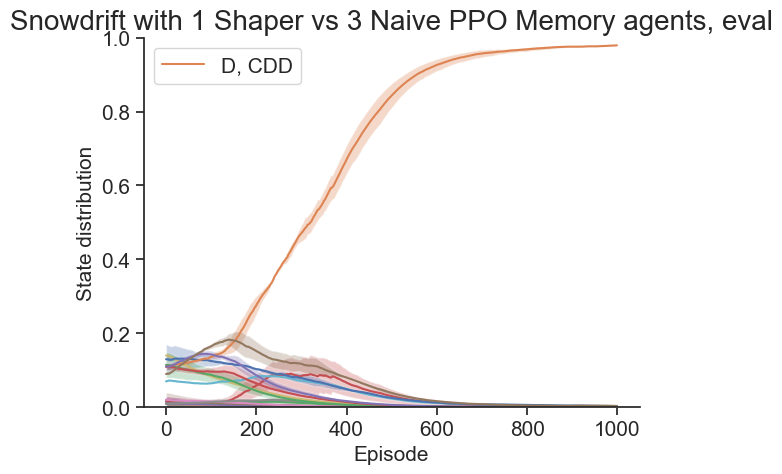

In [95]:
plot_3pl_states("sd",4,1,'eval', only_seeds=[2,3,4], smooth_factor=0.99, grouped=True, legend = [(1,2),(1,3), (1,1), (1,0)]).show()
plot_3pl_states("sd",4,1,'eval', only_seeds=[1,5], smooth_factor=0.99, legend=["DCDD"]).show()

### 2 shapers

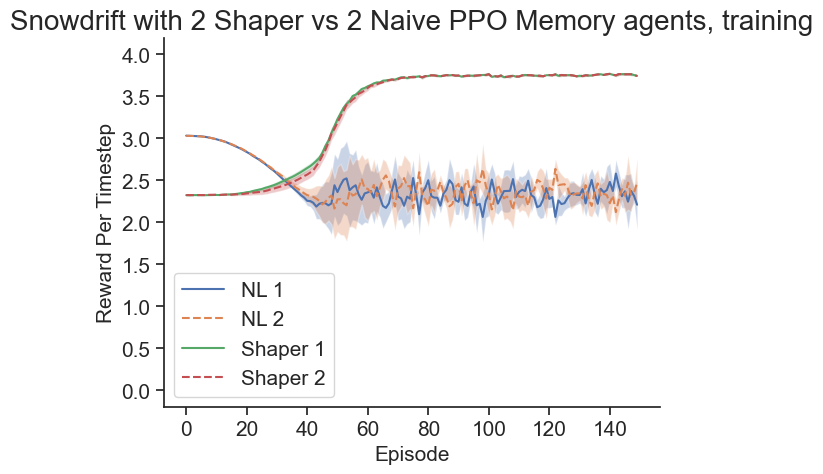

In [9]:
plot_shaper_rewards("sd",4,2,'training', smooth_factor=0.5).show()

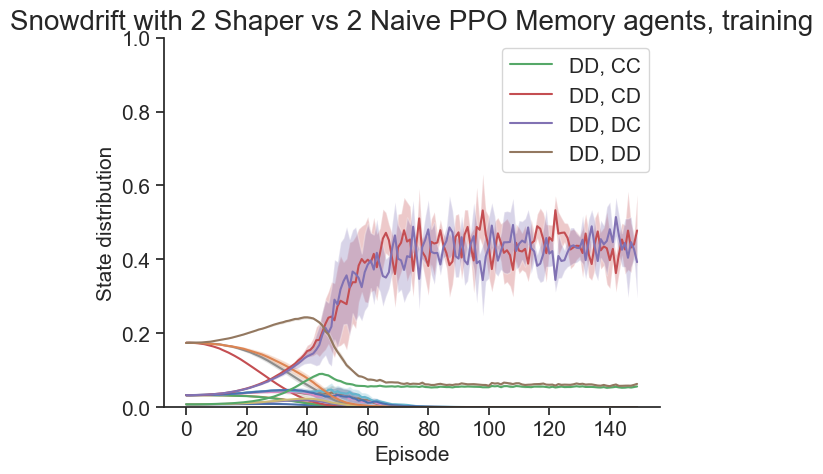

In [100]:
plot_3pl_states("sd",4,2,'training', smooth_factor=0.5, legend=["DDCD","DDDC", "DDDD", "DDCC"]).show()

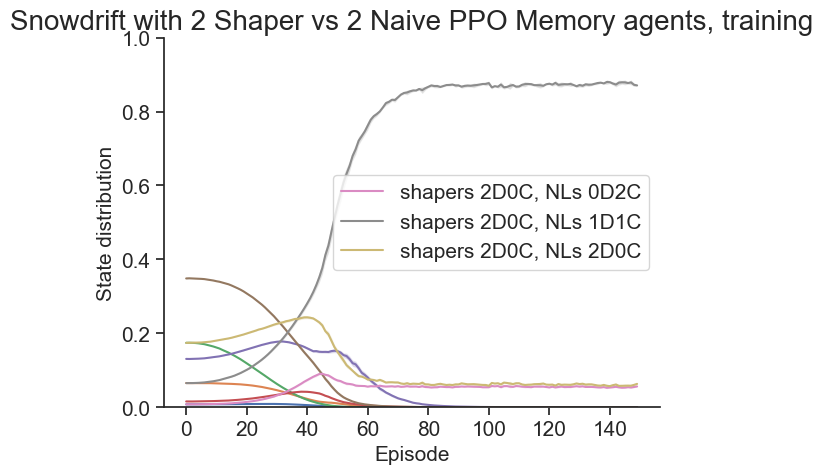

In [101]:
plot_3pl_states("sd",4,2,'training', smooth_factor=0.5, legend=[(2,1), (2,0), (2,2)], grouped=True).show()

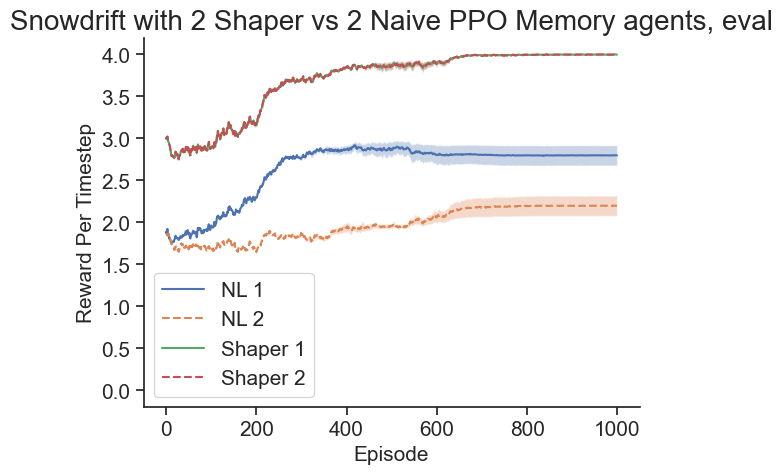

In [13]:
plot_shaper_rewards("sd",4,2,'eval', smooth_factor=0.5).show()

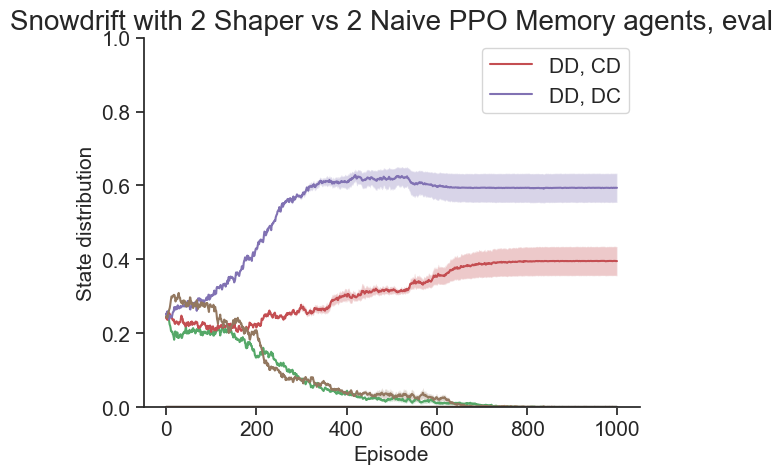

In [103]:
plot_3pl_states("sd",4,2,'eval', smooth_factor=0.5, legend=["DDCD","DDDC"]).show()

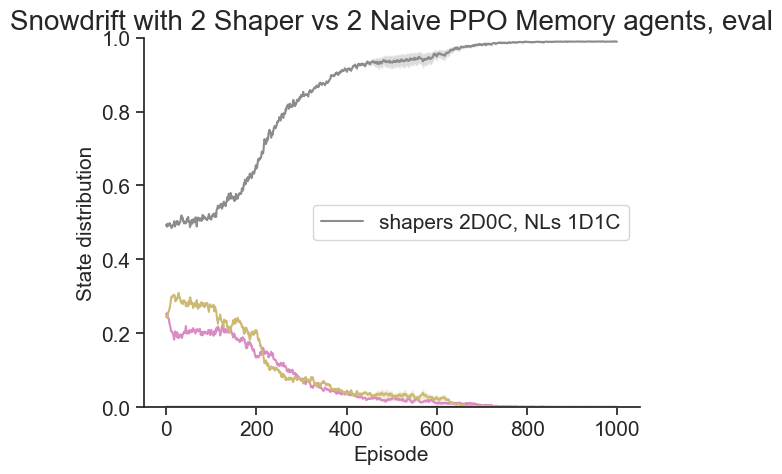

In [104]:
plot_3pl_states("sd",4,2,'eval',grouped=True, smooth_factor=0.5, legend=[(2,1)]).show()

### 3 shapers

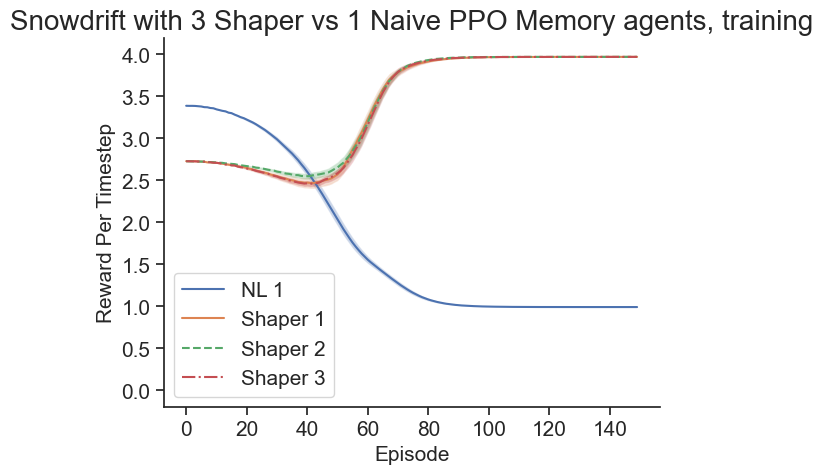

In [14]:
plot_shaper_rewards("sd",4,3,'training').show()

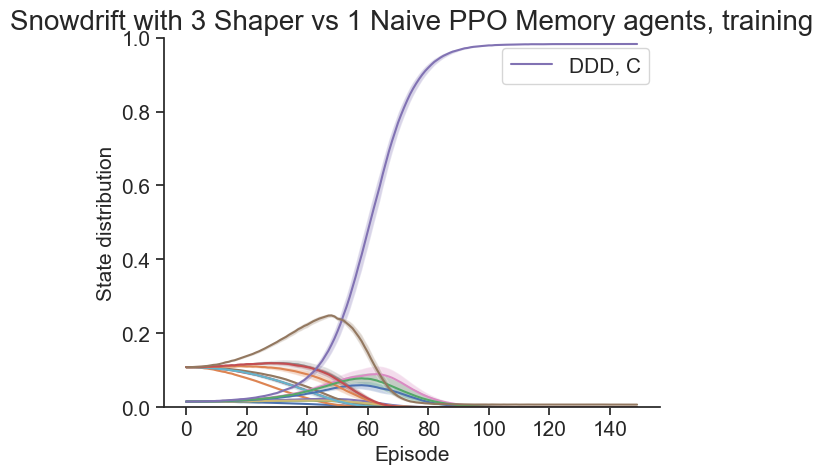

In [107]:
plot_3pl_states("sd",4,3,'training', legend=["DDDC"]).show()

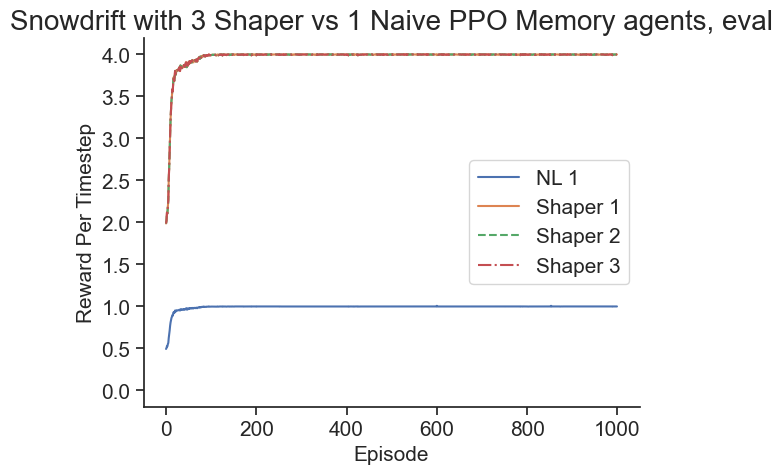

In [15]:
plot_shaper_rewards("sd",4,3,'eval').show()

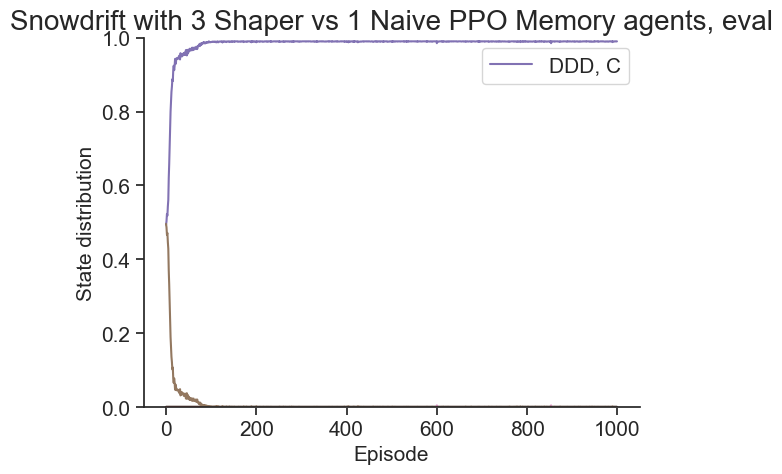

In [108]:
plot_3pl_states("sd",4,3,'eval', legend=["DDDC"]).show()

## SH 3pl


### Naive


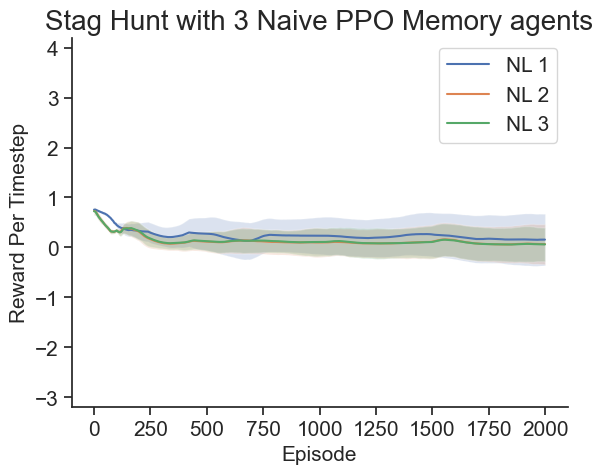

In [159]:
plot_naive_rewards("sh",3).show()

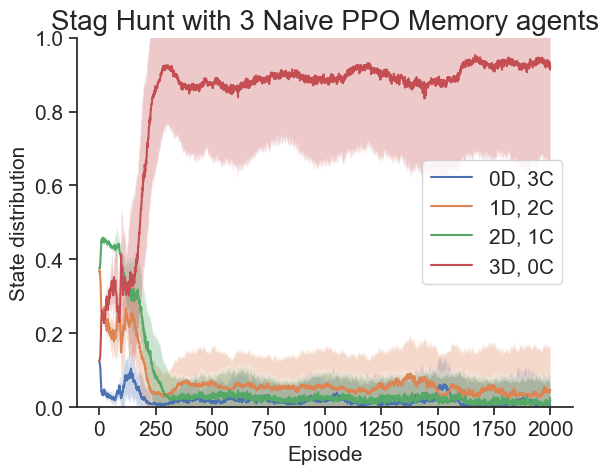

In [109]:
plot_naive_states("sh",3).show()

### 1 shaper
seeds 1,2,4 is really good, shaper gets max score - can we ditch the rest?  
seed 5 is a bit worse and tbh didn't converge   
seed 3 is really bad, they just weirdly defected idk whats up with that


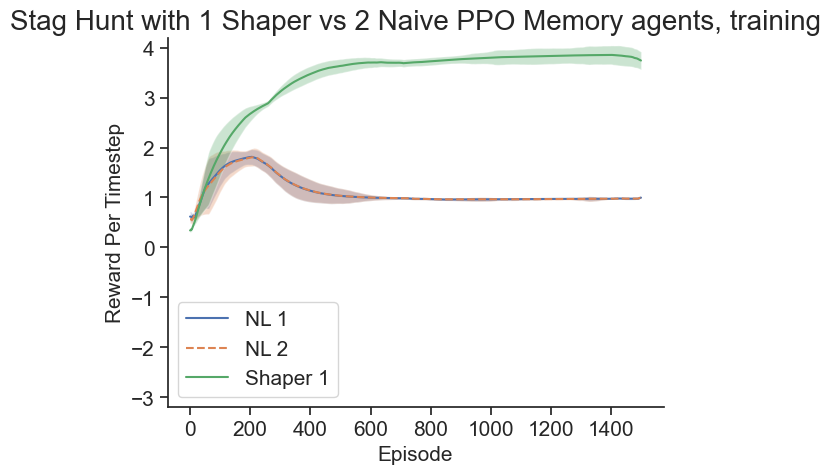

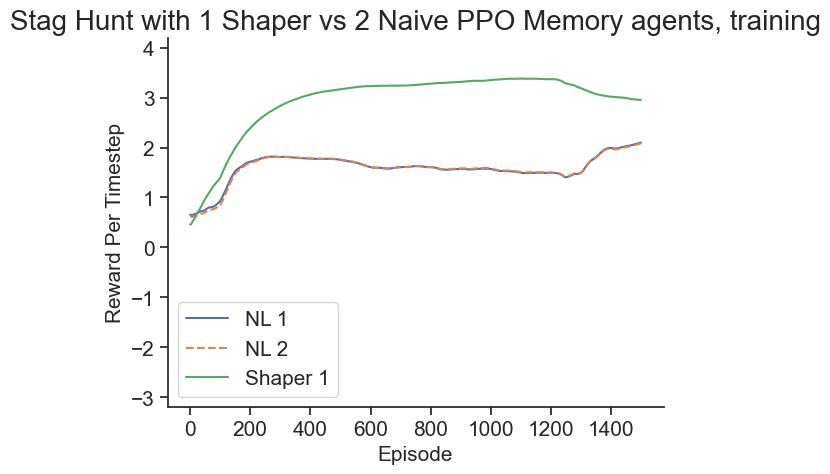

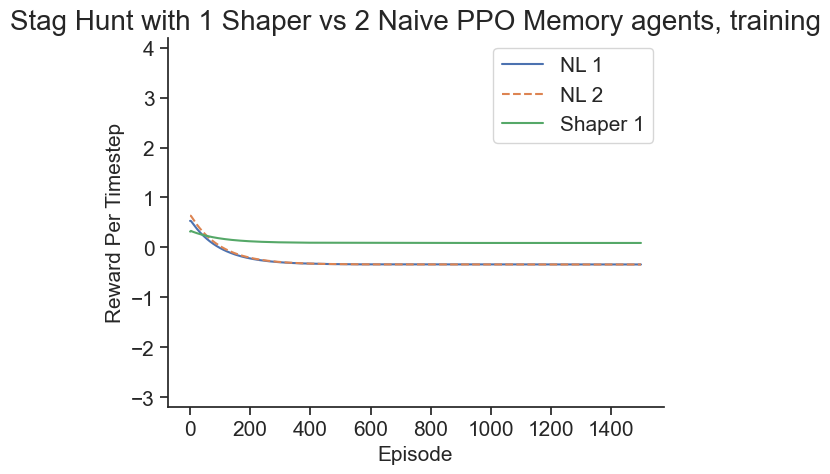

In [45]:
plot_shaper_rewards("sh",3,1,'training', smooth_factor=0.99, only_seeds=[1,2,4]).show()
plot_shaper_rewards("sh",3,1,'training', smooth_factor=0.99, only_seeds=[5]).show()
plot_shaper_rewards("sh",3,1,'training', smooth_factor=0.99, only_seeds=[3]).show()

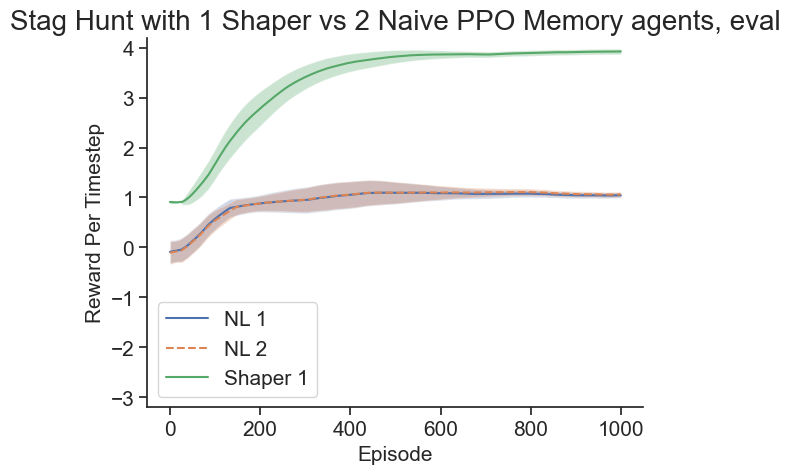

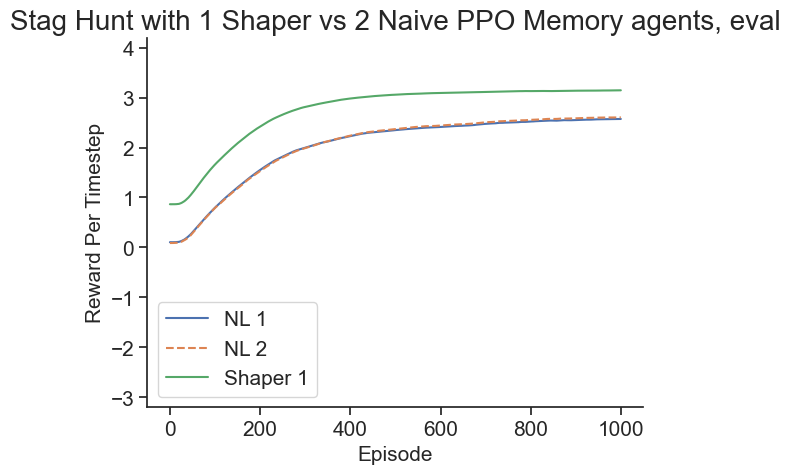

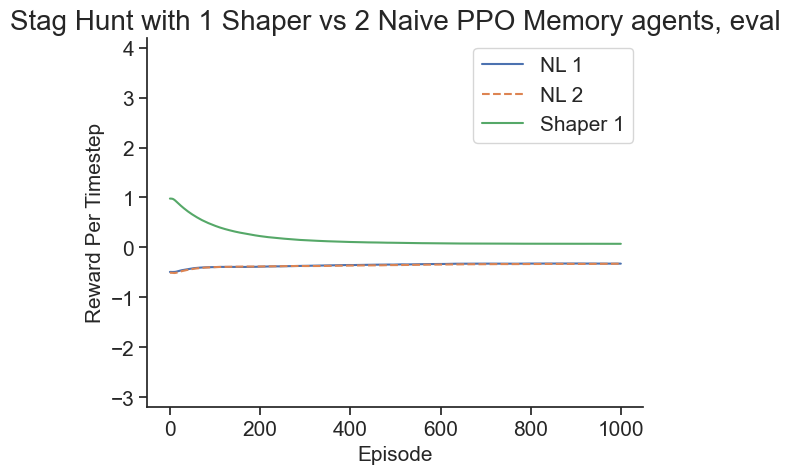

In [47]:

plot_shaper_rewards("sh",3,1,'eval', smooth_factor=0.99, only_seeds=[1,2,4]).show()
plot_shaper_rewards("sh",3,1,'eval', smooth_factor=0.99, only_seeds=[5]).show()
plot_shaper_rewards("sh",3,1,'eval', smooth_factor=0.99, only_seeds=[3]).show()


### 2 shaper


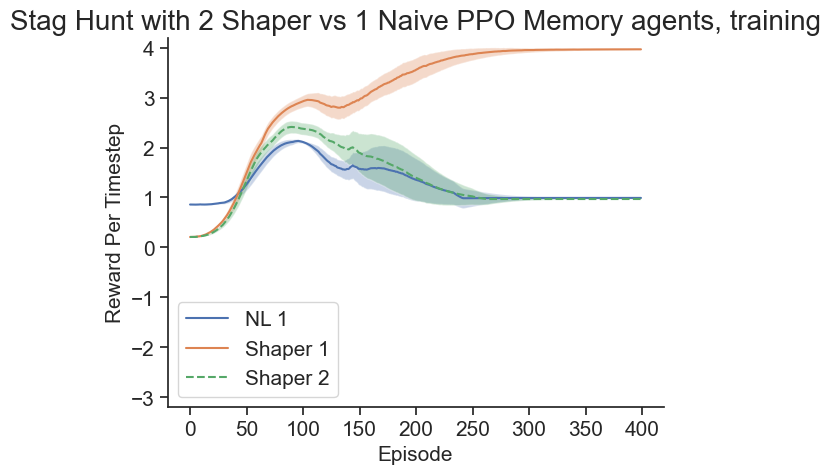

In [52]:
plot_shaper_rewards("sh",3,2,'training', smooth_factor=0.5, flip_dict={1:[1,0],3:[1,0]}).show()


In [182]:
plot_shaper_rewards("sh",3,2,'eval', smooth_factor=0, flip_dict={1:[1,0],3:[1,0]}).show()

[1, 0]
dict_keys([0])


IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

## SH 4pl


### Naive


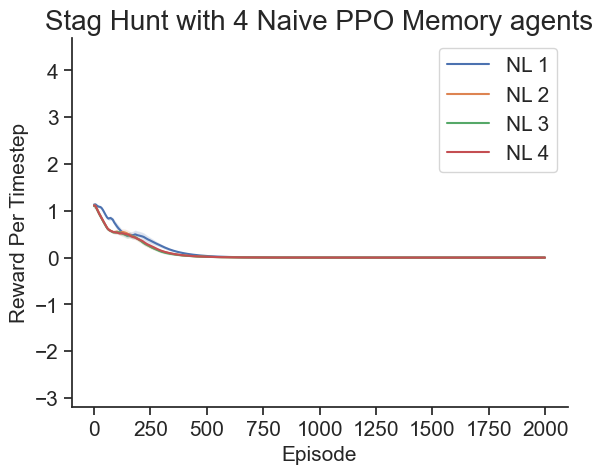

In [80]:
plot_naive_rewards("sh",4).show()


### 1 shaper


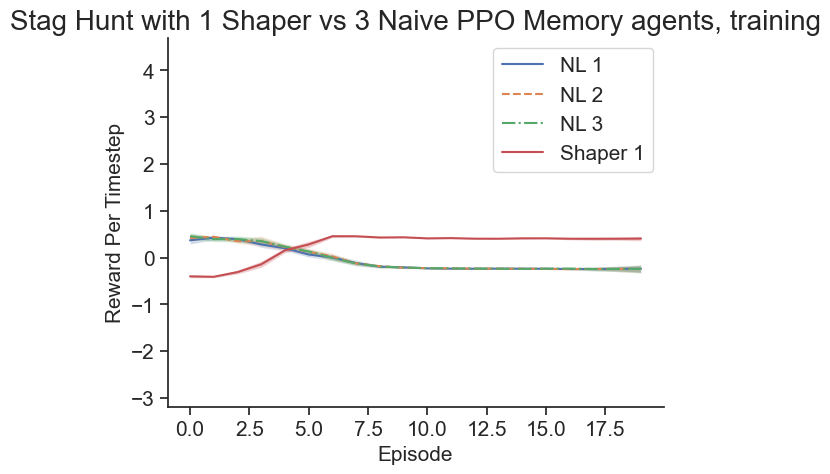

In [81]:
plot_shaper_rewards("sh",4,1,'training', smooth_factor=0).show()


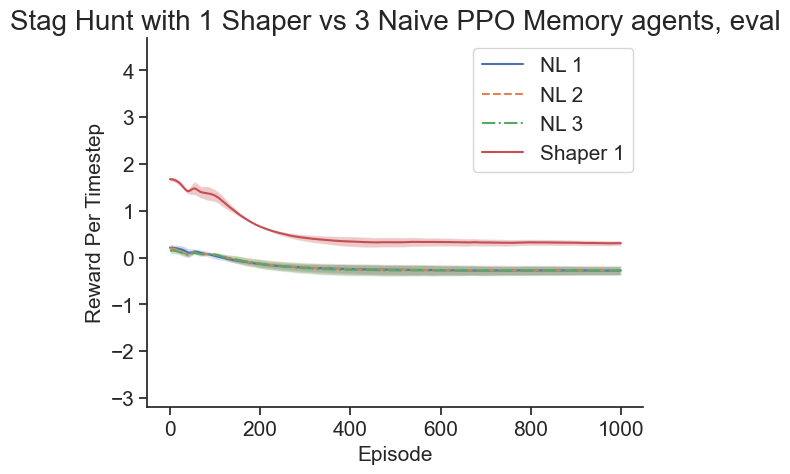

In [85]:
plot_shaper_rewards("sh",4,1,'eval',  smooth_factor=0.99).show()


### 2 shapers


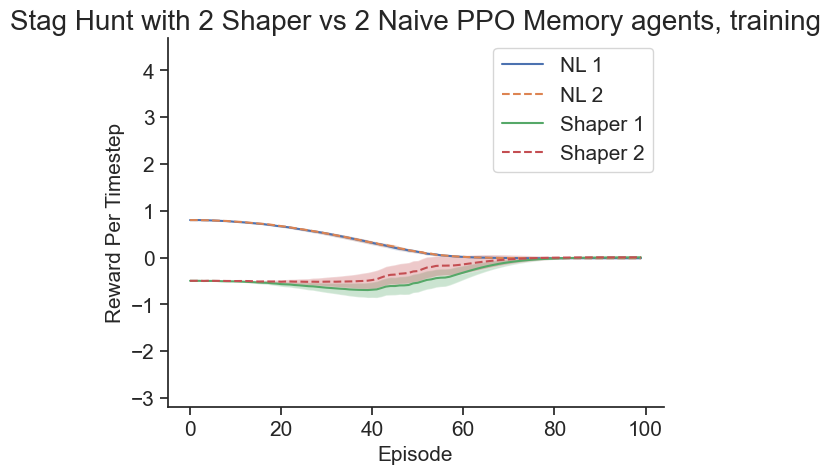

In [86]:
plot_shaper_rewards("sh",4,2,'training', smooth_factor=0).show()


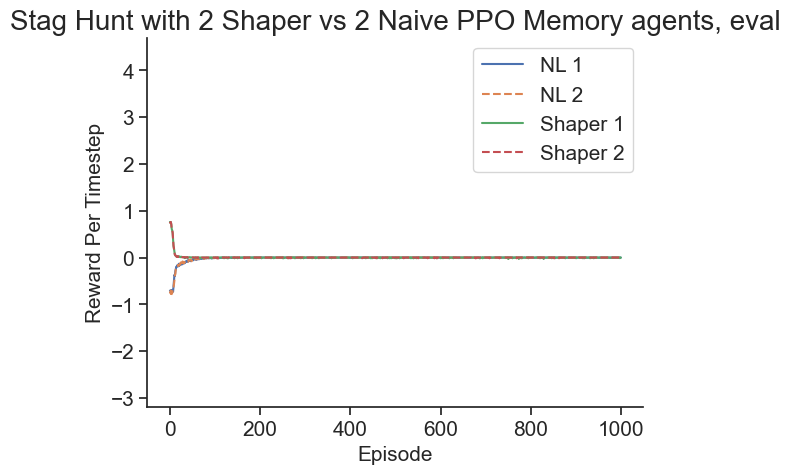

In [87]:
plot_shaper_rewards("sh",4,2,'eval', smooth_factor=0).show()


### 3 shapers


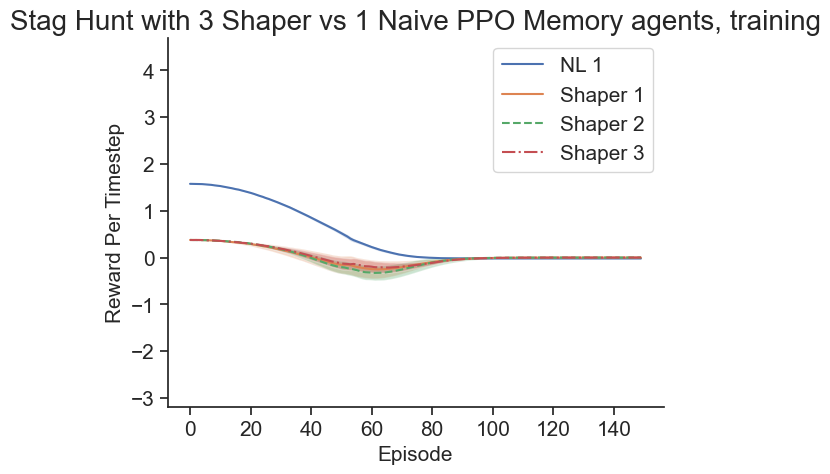

In [89]:
plot_shaper_rewards("sh",4,3,'training').show()


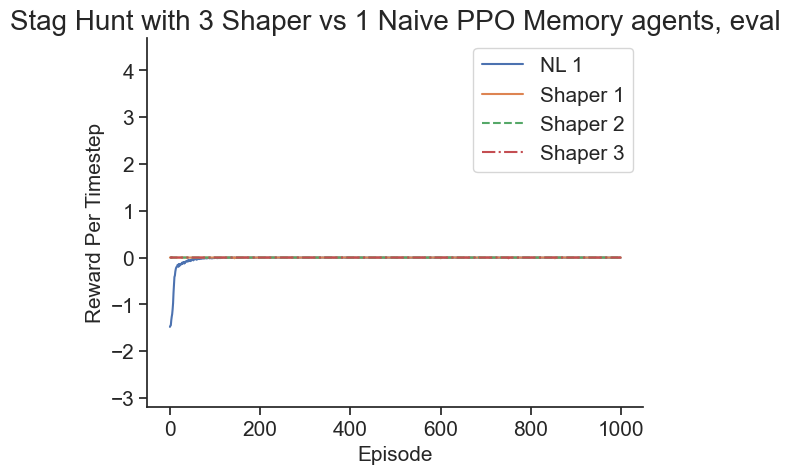

In [90]:
plot_shaper_rewards("sh",4,3,'eval').show()

## TC 3pl


### Naive


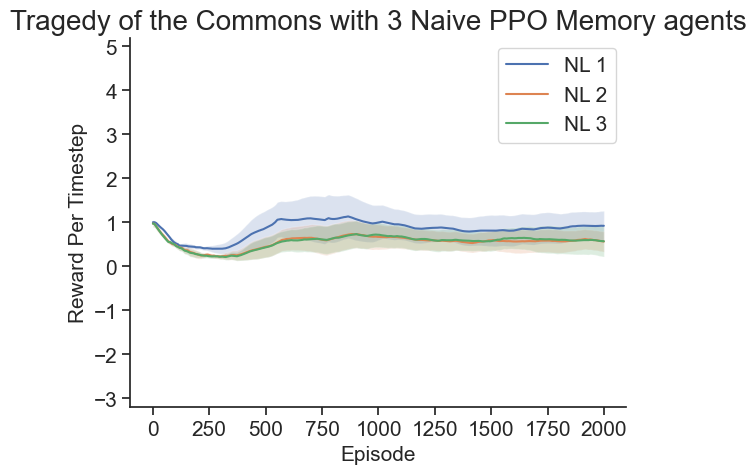

In [8]:
plot_naive_rewards("tc",3, smooth_factor=0.99).show()


### 1 shaper


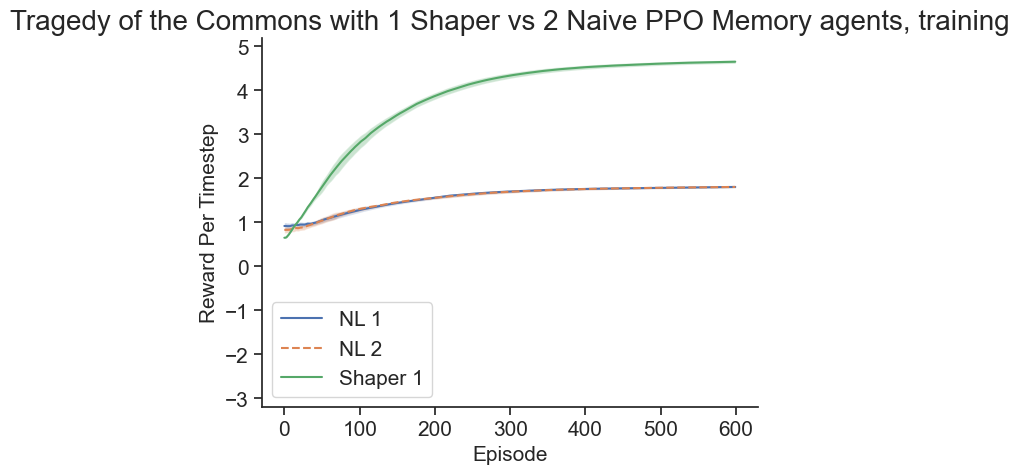

In [10]:
plot_shaper_rewards("tc",3,1,'training', smooth_factor=0.99).show()

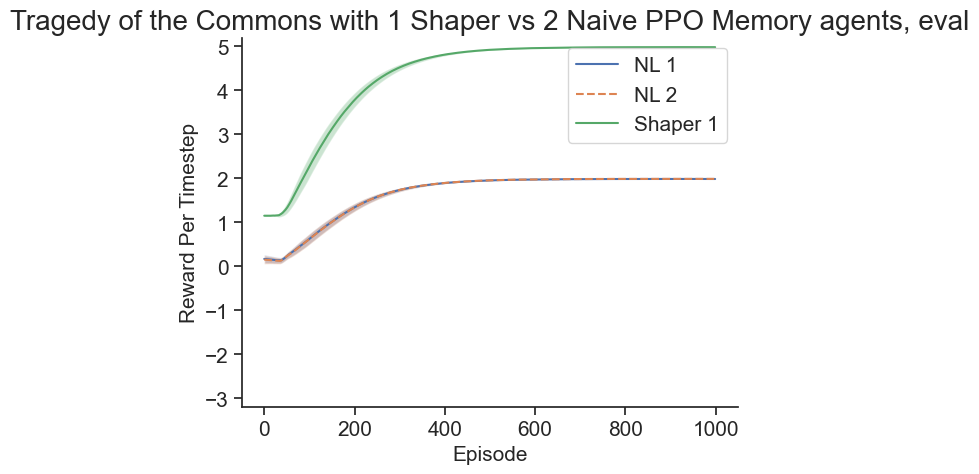

In [12]:

plot_shaper_rewards("tc",3,1,'eval', smooth_factor=0.99).show()


### 2 shaper


[1, 0, 2]
dict_keys([0])
0
[1, 0, 2]
dict_keys([0])
0


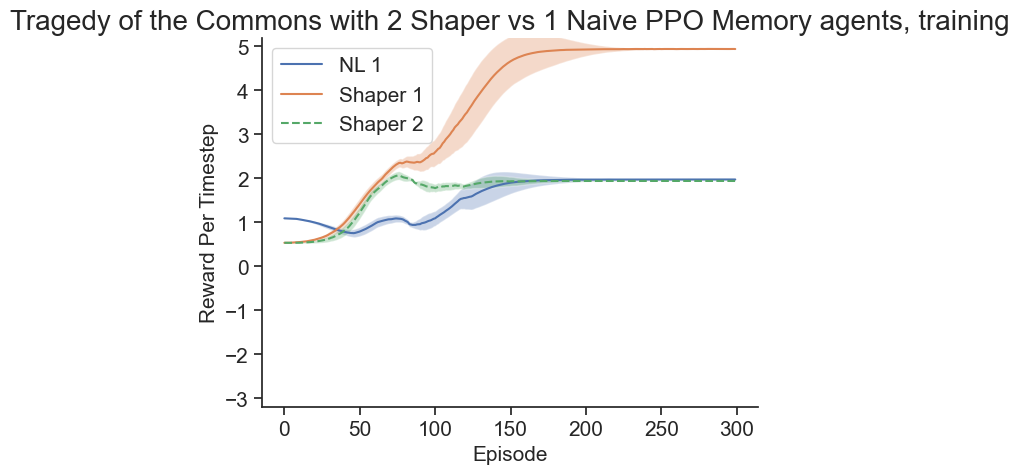

In [183]:
plot_shaper_rewards("tc",3,2,'training', flip_dict={1:[1,0,2],3:[1,0,2]}, smooth_factor=0.5).show()


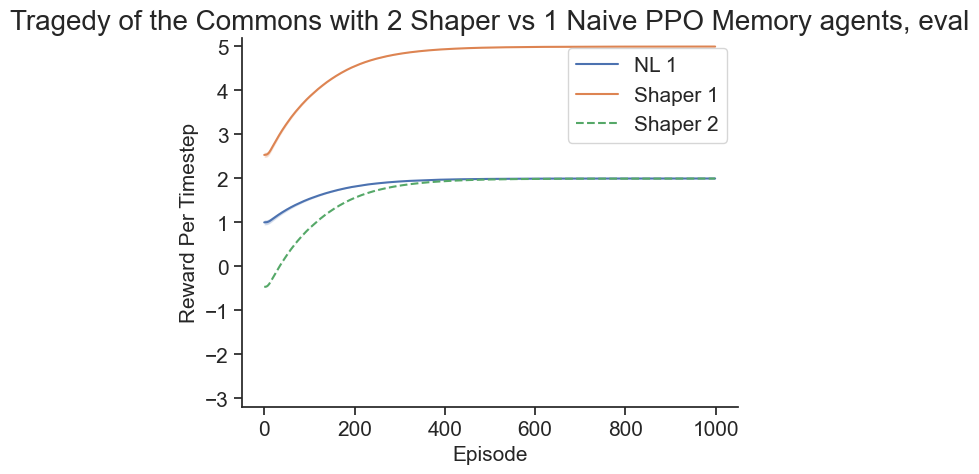

In [18]:
plot_shaper_rewards("tc",3,2,'eval',  flip_dict={1:[1,0],3:[1,0]},smooth_factor=0.99).show()

## TC 4pl


### Naive


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


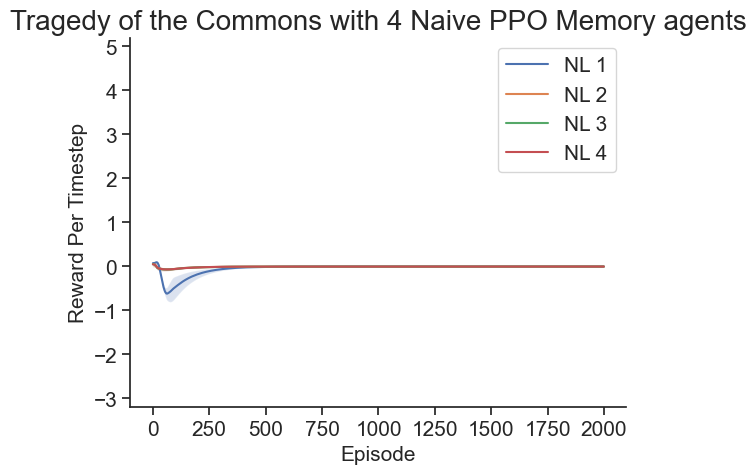

In [66]:
plot_naive_rewards("tc",4).show()


### 1 shaper
seed 3 is weird


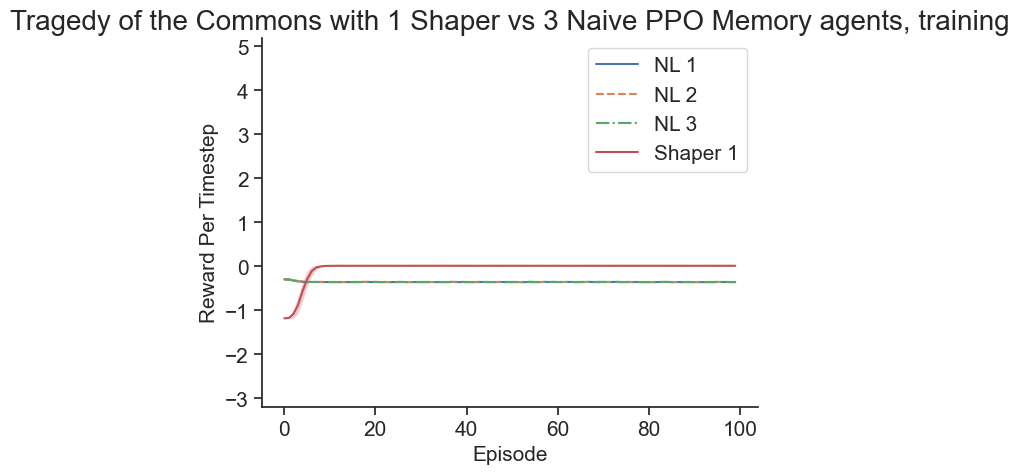

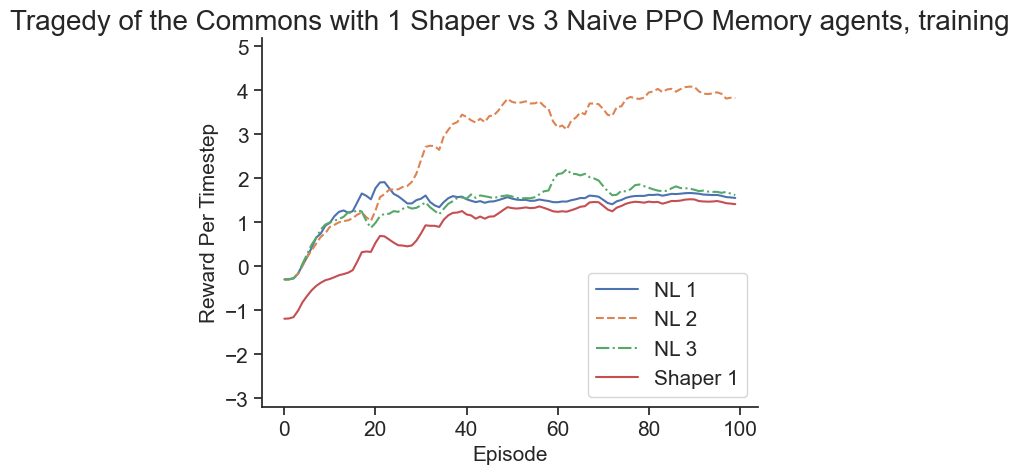

In [24]:
plot_shaper_rewards("tc",4,1,'training',only_seeds=[1,2,4,5], smooth_factor=0).show()
plot_shaper_rewards("tc",4,1,'training',only_seeds=[3], smooth_factor=0.7).show()

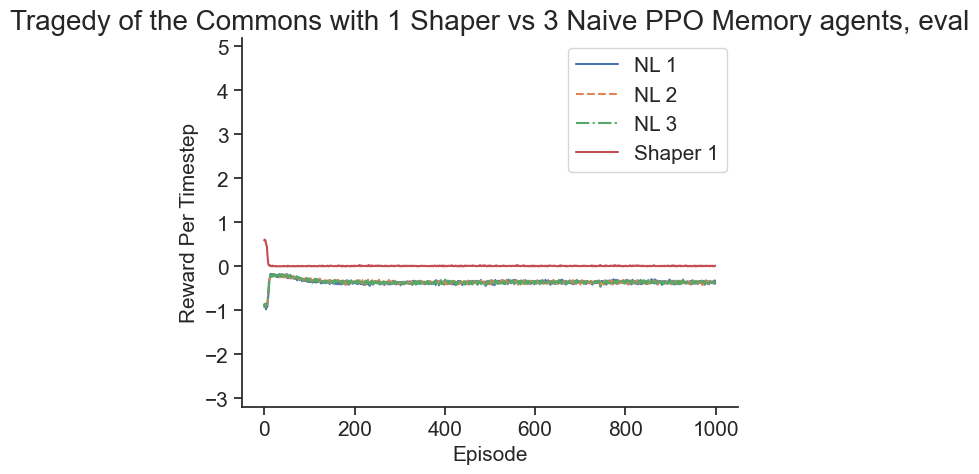

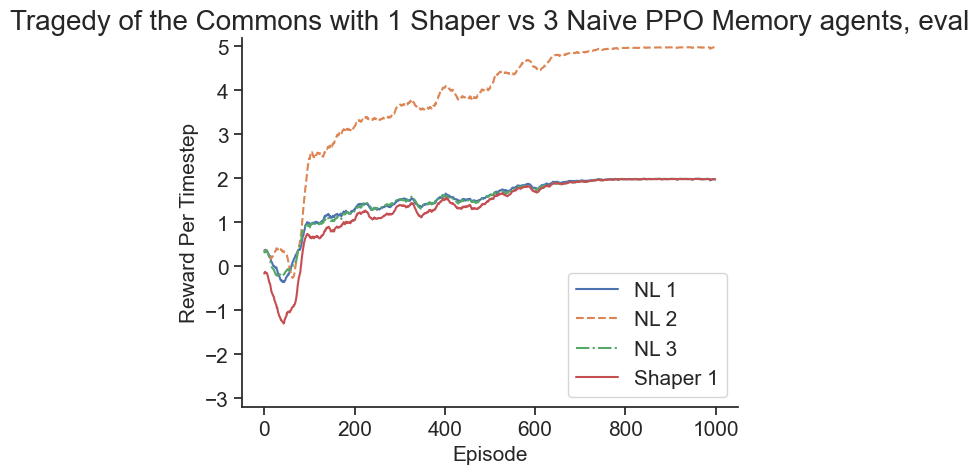

In [26]:
plot_shaper_rewards("tc",4,1,'eval',only_seeds=[1,2,4,5], smooth_factor=0).show()
plot_shaper_rewards("tc",4,1,'eval',only_seeds=[3], smooth_factor=0.7).show()

### 2 shapers


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


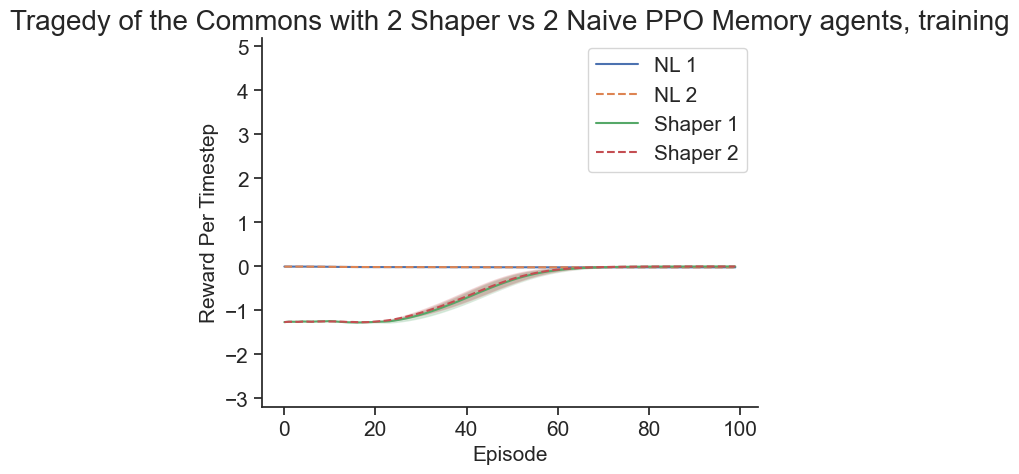

In [27]:
plot_shaper_rewards("tc",4,2,'training', smooth_factor=0.5).show()


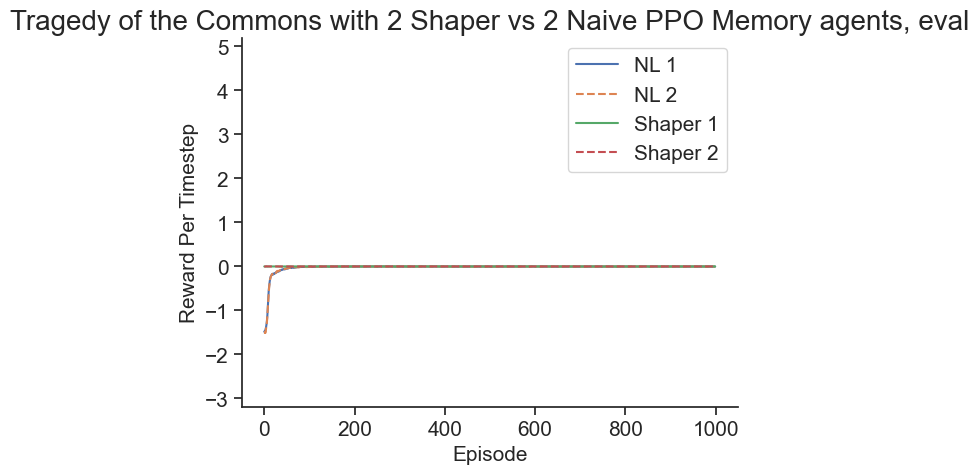

In [28]:
plot_shaper_rewards("tc",4,2,'eval', smooth_factor=0.5).show()


### 3 shapers


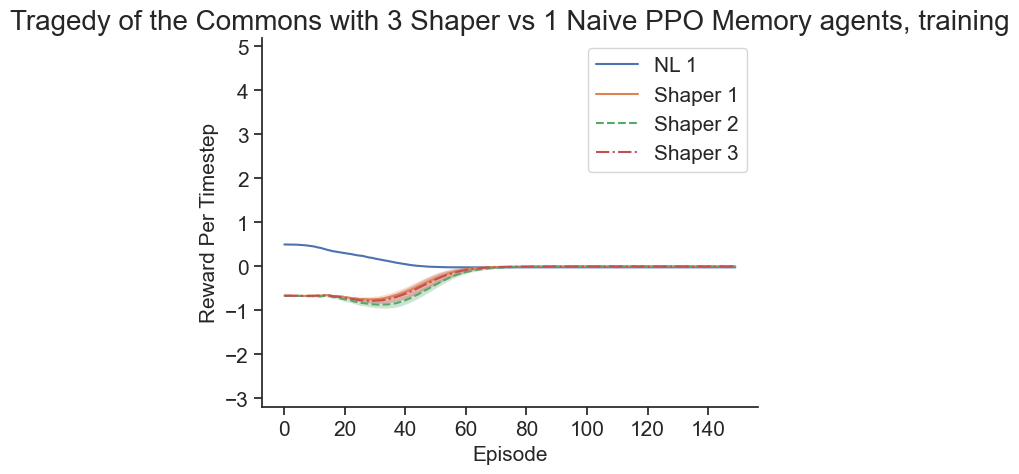

In [29]:
plot_shaper_rewards("tc",4,3,'training').show()


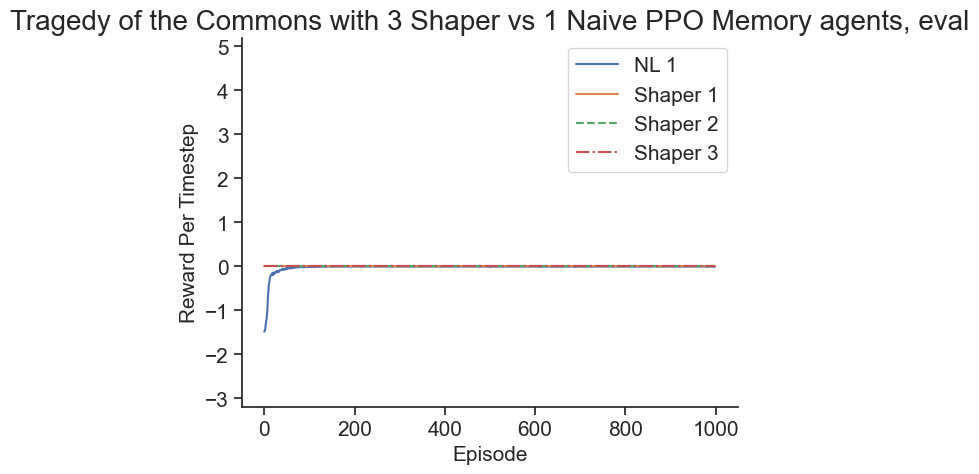

In [30]:
plot_shaper_rewards("tc",4,3,'eval').show()

## IPD 3pl



### Naive


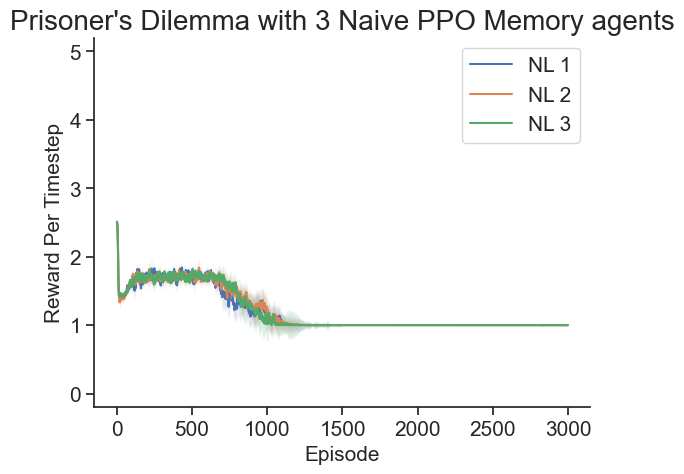

In [46]:

plot_naive_rewards("ipd",3, smooth_factor=0).show()



### 1 shaper

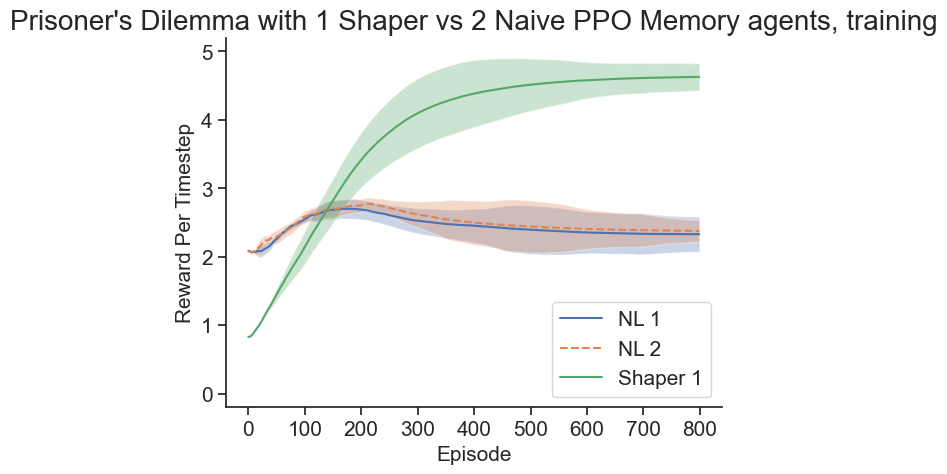

In [56]:

plot_shaper_rewards("ipd",3,1,'training',only_seeds=[0,1,2,3,4], smooth_factor=0.99).show()


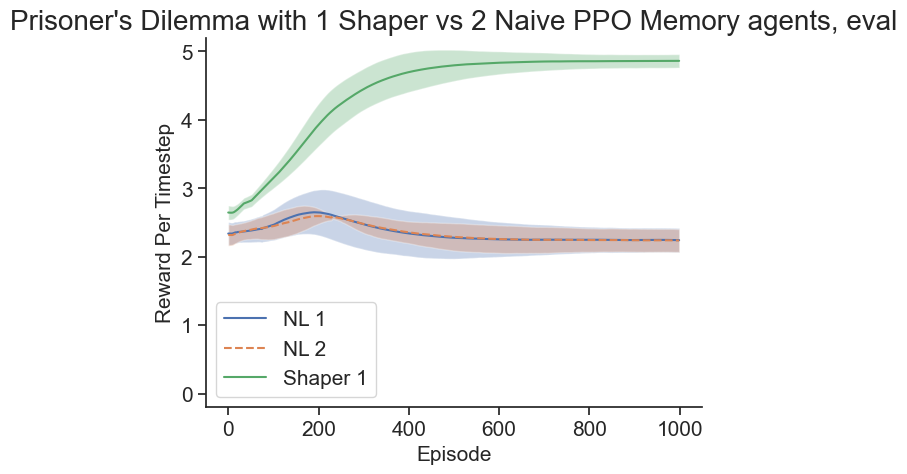

In [57]:

plot_shaper_rewards("ipd",3,1,'eval', smooth_factor=0.99).show()



### 2 shaper


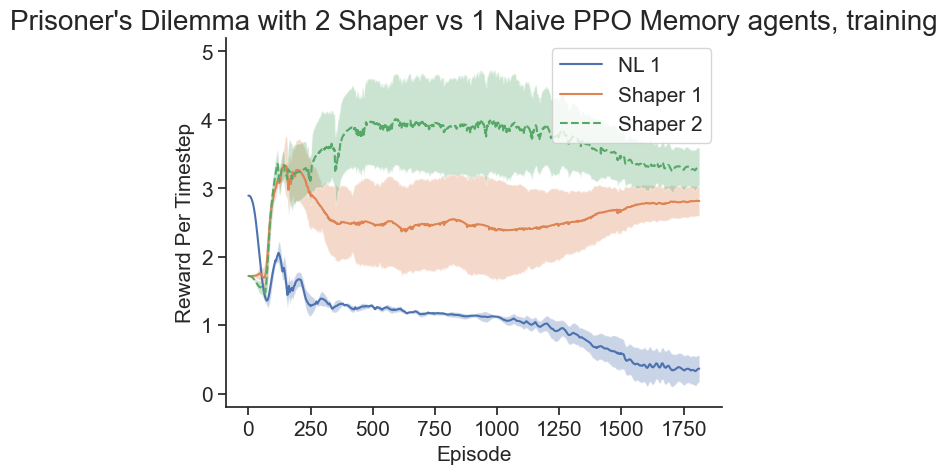

In [65]:

plot_shaper_rewards("ipd",3,2,'training', flip_dict={3:[1,0]}, smooth_factor=0.7, crop_to_shortest=True).show()


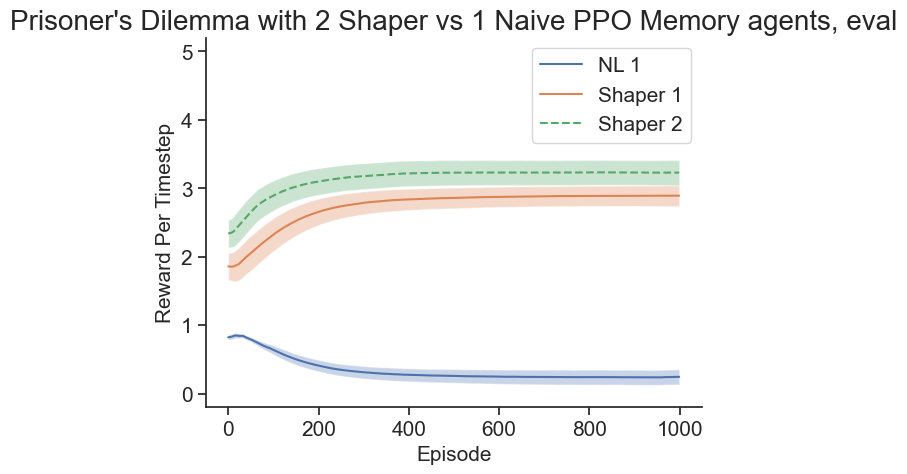

In [59]:

plot_shaper_rewards("ipd",3,2,'eval',  flip_dict={3:[1,0]},smooth_factor=0.99).show()

## IPD 4pl



### Naive


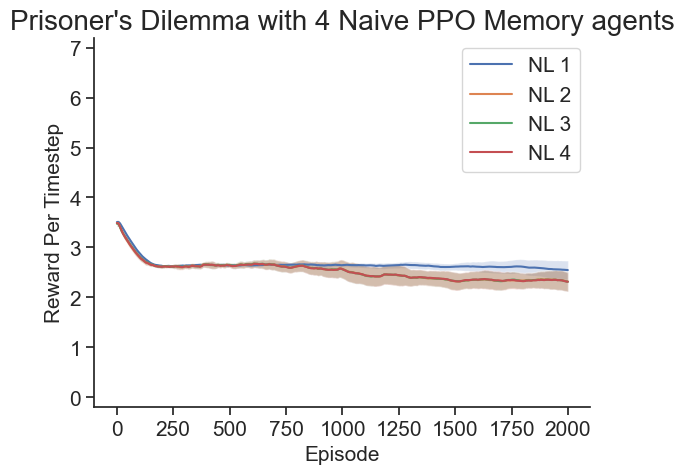

In [69]:

plot_naive_rewards("ipd",4).show()



### 1 shaper
Not great, seed 0 looks good others are kind of garbage

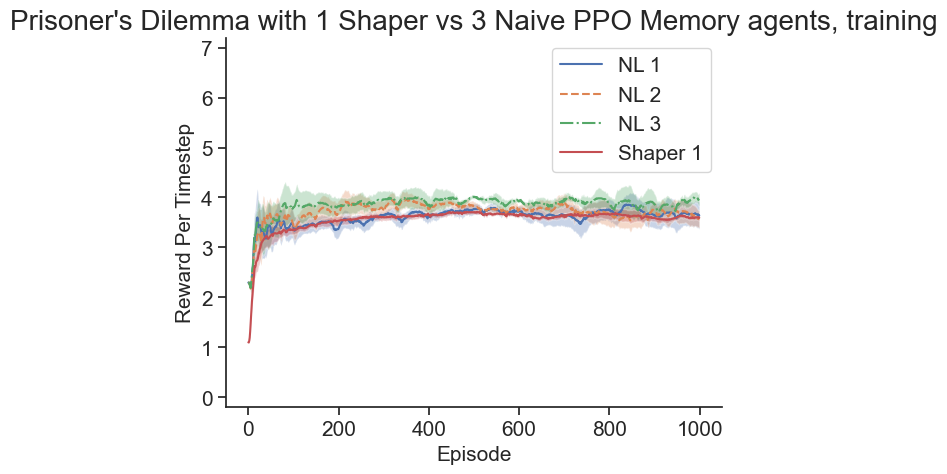

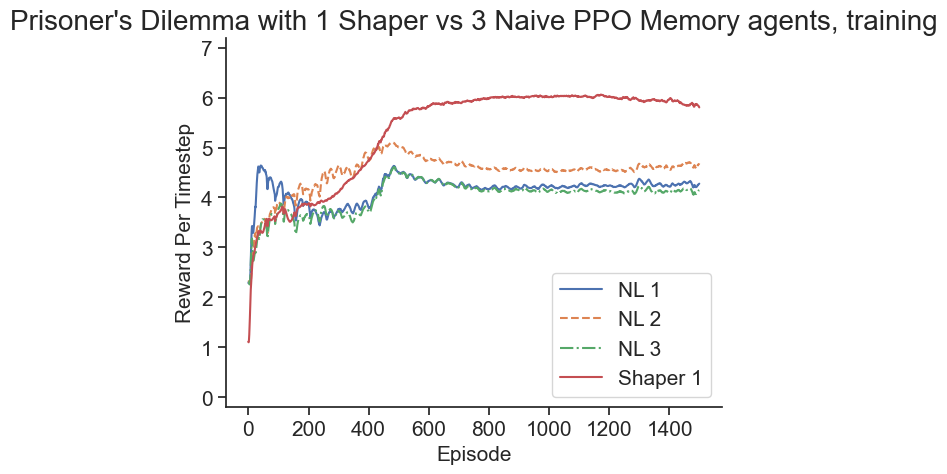

In [80]:

plot_shaper_rewards("ipd",4,1,'training', smooth_factor=0.7, crop_to_shortest=True, only_seeds=[1,2,3,4,5]).show()
plot_shaper_rewards("ipd",4,1,'training', smooth_factor=0.7, only_seeds=[0]).show()


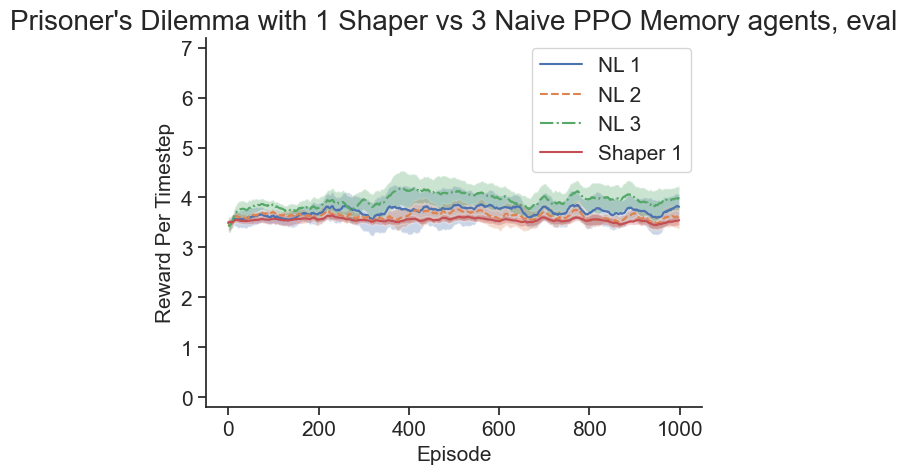

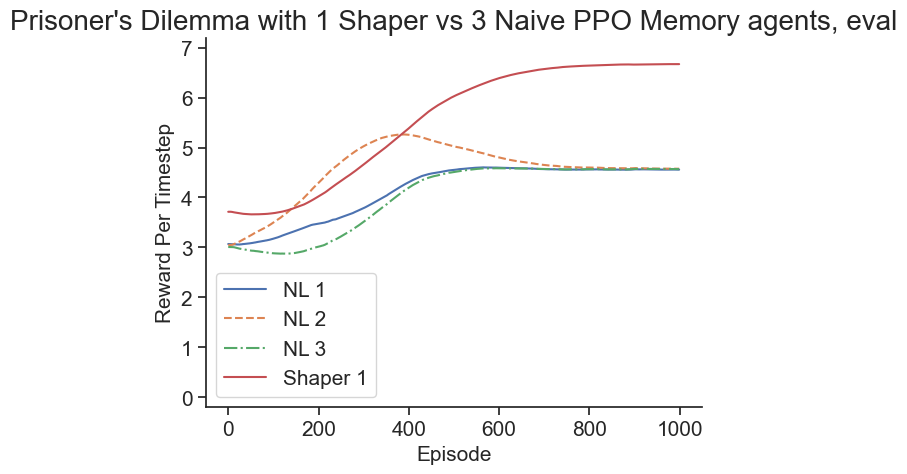

In [79]:
plot_shaper_rewards("ipd",4,1,'eval', smooth_factor=0.9, only_seeds=[1,2,3,4,5]).show()
plot_shaper_rewards("ipd",4,1,'eval', smooth_factor=0.99, only_seeds=[0]).show()


### 2 shapers


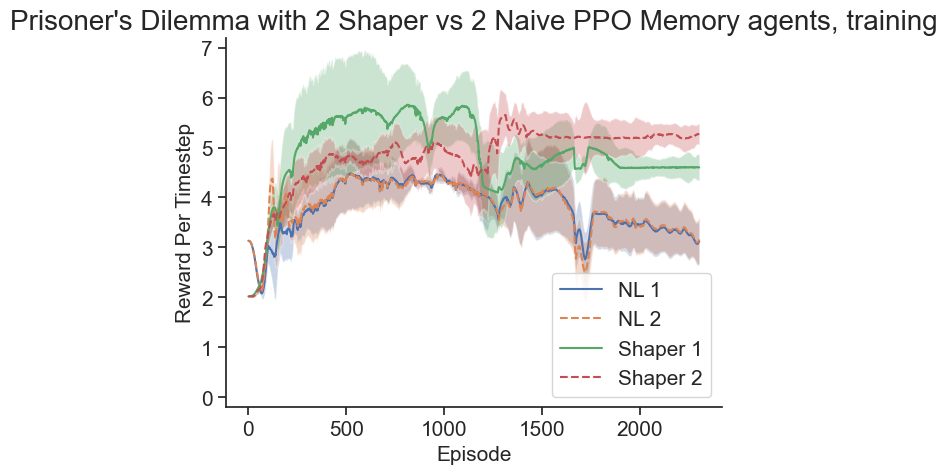

In [89]:

plot_shaper_rewards("ipd",4,2,'training', smooth_factor=0.7, crop_to_shortest=True, only_seeds=[1,5,3]).show() #other seeds same, but runs were much shorter


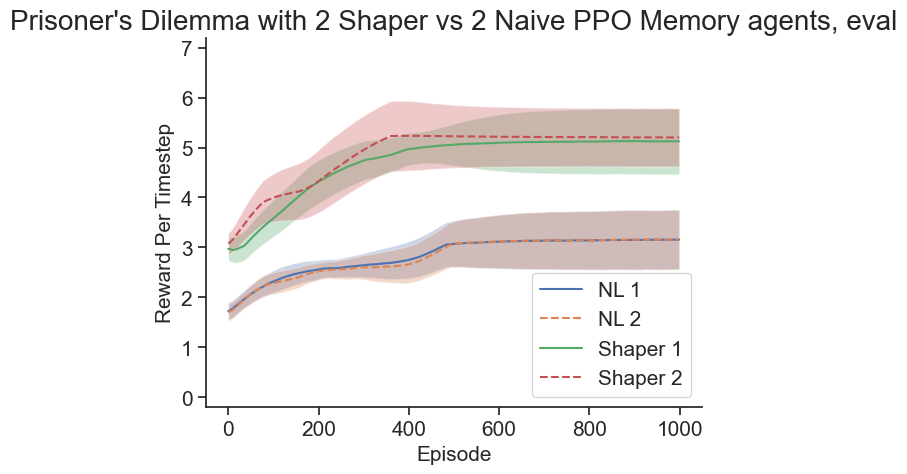

In [86]:

plot_shaper_rewards("ipd",4,2,'eval', smooth_factor=0.99).show()



### 3 shapers


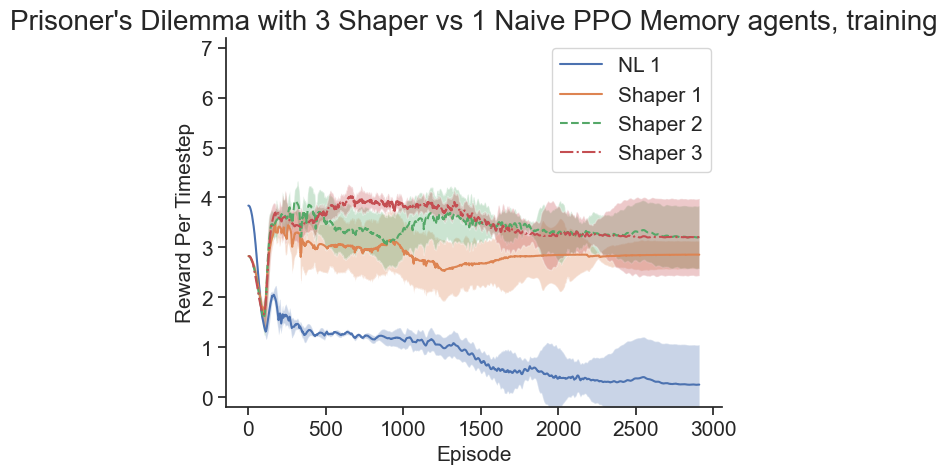

In [112]:

plot_shaper_rewards("ipd",4,3,'training', crop_to_shortest=True, smooth_factor=0.7, flip_dict={2:[1,0,2,3], 5:[2,1,0,3]}).show()


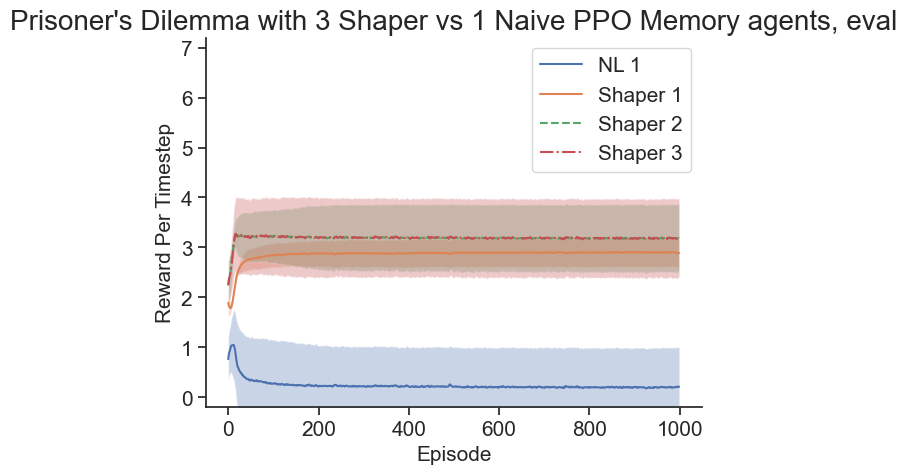

In [113]:
plot_shaper_rewards("ipd",4,3,'eval', smooth_factor=0.7, flip_dict={2:[1,0,2,3], 5:[2,1,0,3]}).show()


## Scores


### naive and lola

In [82]:
def get_naive_scores_at_ep(game,num_pl, episode):
    runs = api.runs(path="ucl-dark/tensor",
    filters={"config.wandb.group": f"op1_naive_{num_pl}pl_{game}"})
    rewards_dict = {pl_idx: [] for pl_idx in range(num_pl)}
    xs = []

    for run in runs:
        rew_keys = [f'train/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_pl)]
        df = run.scan_history(keys=rew_keys+['train_iteration'])
        for pl_idx in range(num_pl):
            rewards_dict[pl_idx].append([row[f'train/reward_per_timestep/player_{pl_idx+1}'] for row in df])
    _xs = np.array(xs)
    smooth_rewards_dict = rewards_dict
    # smooth_rewards_dict = {pl_idx: vmap_smooth(np.array(rewards_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl)}
    all_rew = np.stack([smooth_rewards_dict[pl_idx] for pl_idx in range(num_pl)], axis=0)
    all_means = np.mean(all_rew[:,:,episode])
    all_stds = np.std(all_rew[:,:,episode])
    return_dict = {}
    return_dict['all'] = (all_means, all_stds)
    return return_dict

def get_naive_rewards():
    rew_dict = {}
    for game in ["sd", "sh", "tc", "ipd"]:
        for num_pl in [3,4,5]:
            rew_dict[game+str(num_pl)] = get_naive_scores_at_ep(game,num_pl, 2990)
            print(game+str(num_pl))
            print(rew_dict[game+str(num_pl)])
    return rew_dict


In [83]:
rew_dict =get_naive_rewards()

sd3
{'all': (2.054974382122358, 0.6813829630867524)}
sd4
{'all': (2.5287274360656737, 0.140497790406091)}
sd5
{'all': (3.6767563676834105, 0.05492101108744682)}
sh3
{'all': (-9.99999950484683e-06, 5.3851645404863616e-05)}
sh4
{'all': (-1.4999999257270246e-05, 6.538348091562618e-05)}
sh5
{'all': (-5.999999702908099e-06, 4.199999792035668e-05)}
tc3
{'all': (-2.9999998514540493e-05, 8.99999955436215e-05)}
tc4
{'all': (-2.249999888590537e-05, 7.90173992338238e-05)}
tc5
{'all': (-1.7999999108724296e-05, 7.124604899445663e-05)}
ipd3
{'all': (1.0003899892171224, 0.0012754886849530701)}
ipd4
{'all': (1.0074874877929687, 0.0176158087665491)}
ipd5
{'all': (3.415993919372559, 0.08919974668173514)}


In [ ]:
def get_lola_scores_at_ep(game,num_pl, episode):
    runs = api.runs(path="ucl-dark/tensor",
    filters={"config.wandb.group": f"lola_{num_pl}pl_{game}"})
    rewards_dict = {pl_idx: [] for pl_idx in range(num_pl)}

    for run in runs:
        rew_keys = [f'train/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_pl)]
        df = run.scan_history(keys=rew_keys+['train_iteration'])
        for pl_idx in range(num_pl):
            rewards_dict[pl_idx].append([row[f'train/reward_per_timestep/player_{pl_idx+1}'] for row in df])
    smooth_rewards_dict = rewards_dict
    # smooth_rewards_dict = {pl_idx: vmap_smooth(np.array(rewards_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl)}
    all_rew = np.stack([smooth_rewards_dict[pl_idx] for pl_idx in range(num_pl)], axis=0)
    lola_means = np.mean(all_rew[0,:,episode], axis=0)
    lola_stds = np.std(all_rew[0,:,episode], axis=0)

    opponent_means = np.mean(all_rew[1:,:,episode])
    opponent_stds = np.std(all_rew[1:,:,episode])

    all_means = np.mean(all_rew[:,:,episode])
    all_stds = np.std(all_rew[:,:,episode])


    return_dict = {}
    return_dict['lola'] = (lola_means, lola_stds)
    return_dict['all'] = (all_means, all_stds)
    return_dict["opponents"] = (opponent_means, opponent_stds)
    return return_dict

def get_lola_rewards():
    rew_dict = {}
    for game in ["sd", "sh", "tc", "ipd"]:
        for num_pl in [3,4,5]:
            rew_dict[game+str(num_pl)] = get_lola_scores_at_ep(game,num_pl, 1994)
            print(game+str(num_pl))
            print(rew_dict[game+str(num_pl)])
    return rew_dict

In [69]:
rew_dict =get_lola_rewards()

sd3
{'lola': (1.9459940910339355, 0.4257925577935467), 'all': (2.1000930507977804, 0.4317903126653276), 'opponents': (2.1771425306797028, 0.4137690092080633)}
sd4
{'lola': (2.716527673933241, 0.29517549290495837), 'all': (2.7485249174965753, 0.41302409633047343), 'opponents': (2.75919066535102, 0.4449201976606579)}
sd5
{'lola': (3.6789387861887612, 0.4151819234909465), 'all': (3.8101174460517035, 0.4135323353644449), 'opponents': (3.842912111017439, 0.40655846177453975)}
sh3
{'lola': (0.40103332281837034, 0.3759628589667825), 'all': (0.620122210415839, 0.766033662733035), 'opponents': (0.7296666542145734, 0.8795097313262218)}
sh4
{'lola': (0.037041665623999305, 0.16491120211563068), 'all': (0.14267916126441882, 0.4442724887787719), 'opponents': (0.17789165981122534, 0.49914507974890004)}
sh5
{'lola': (-0.039863330932954945, 0.057914119459530636), 'all': (0.0008766684965747926, 0.042159836754517406), 'opponents': (0.011061668353957228, 0.02940463186798721)}
tc3
{'lola': (1.0298277569106

In [114]:
def get_shaper_scores_at_ep(game,num_pl,num_shap, episode, only_seeds=None,):
    group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}-eval"},{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}_eval"},  {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}-eval"}]}
    runs = api.runs(path=f"ucl-dark/tensor-{game}",
     filters=group_filter)
    
    target_dict = {pl_idx: [] for pl_idx in range(num_pl-num_shap)}
    shaper_dict = {pl_idx: [] for pl_idx in range(num_shap)}
    tag = "eval"
    for run in runs:
        current_seed = run.config["seed"] if tag=="train" else int(run.name.split("-eval")[0][-1]) #evals end w/ seed-eval
        int(current_seed) # make sure it's an int
        if only_seeds is not None and current_seed not in only_seeds:
            continue
        if f'{tag}/reward_per_timestep/target_1' in run.history():
            target_keys = [f'{tag}/reward_per_timestep/target_{pl_idx+1}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/shaper_{pl_idx+1}' for pl_idx in range(num_shap)]
        else:
            target_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1+num_shap}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_shap)]
        df = run.scan_history(keys=target_keys+shaper_keys+['train_iteration'])
        for pl_idx,target_key in zip(range(num_pl-num_shap),target_keys):
            target_dict[pl_idx].append([row[target_key] for row in df])
        for pl_idx,shaper_key in zip(range(num_shap), shaper_keys):
            shaper_dict[pl_idx].append([row[shaper_key] for row in df])

    shaper_stack = np.stack([np.array(shaper_dict[pl_idx]) for pl_idx in range(num_shap)], axis=0)
    target_stack = np.stack([np.array(target_dict[pl_idx]) for pl_idx in range(num_pl-num_shap)], axis=0)
    all_rew = np.concatenate([shaper_stack, target_stack], axis=0)
    all_means = np.mean(all_rew[:,:,episode])
    all_stds = np.std(all_rew[:,:,episode])

    shaper_means = np.mean(all_rew[:num_shap,:,episode])
    shaper_stds = np.std(all_rew[:num_shap,:,episode])

    target_means = np.mean(all_rew[num_shap:,:,episode])
    target_stds = np.std(all_rew[num_shap:,:,episode])

    return_dict = {}

    return_dict['all'] = (all_means, all_stds)
    return_dict["targets"] = (target_means, target_stds)
    return_dict["shapers"] = (shaper_means, shaper_stds)
    return return_dict


### TC

In [108]:
get_shaper_scores_at_ep('tc',3,1,999)

{'all': (2.9853001038233438, 1.4111748391729781),
 'targets': (1.987450087070465, 0.0021029636612911093),
 'shapers': (4.981000137329102, 0.002549437192572247)}

In [116]:

get_shaper_scores_at_ep('tc',3,2,999)


{'all': (2.998666795094808, 1.4137427759154153),
 'targets': (2.0, 0.0),
 'shapers': (3.4980001926422117, 1.5000004763202026)}

In [117]:

get_shaper_scores_at_ep('tc',4,1,999)


{'all': (0.325725020095706, 1.3352763507571817),
 'targets': (0.2978000203768412, 1.4737314328686162),
 'shapers': (0.4095000192523003, 0.7790000356733799)}

In [118]:
get_shaper_scores_at_ep('tc',4,2,999)

{'all': (-0.0006000000052154064, 0.0011022703938337436),
 'targets': (-0.0012000000104308128, 0.0013076696944289167),
 'shapers': (0.0, 0.0)}

In [119]:
get_shaper_scores_at_ep('tc',4,2,999)

{'all': (-0.0006000000052154064, 0.0011022703938337436),
 'targets': (-0.0012000000104308128, 0.0013076696944289167),
 'shapers': (0.0, 0.0)}

In [120]:
get_shaper_scores_at_ep('tc',4,3,999)

{'all': (-0.000750000006519258, 0.001299038116968344),
 'targets': (-0.003000000026077032, 0.0),
 'shapers': (0.0, 0.0)}

In [122]:
get_shaper_scores_at_ep('tc',5,1,999)


{'all': (2.471900088787079, 0.9937738939371035),
 'targets': (2.1083750814199447, 0.6213991862640136),
 'shapers': (3.9260001182556152, 0.866242660558089)}

In [123]:
get_shaper_scores_at_ep('tc',5,2,999)


{'all': (-0.002220000019297004, 0.0022498000106663564),
 'targets': (-0.003700000032161673, 0.0017204650683633996),
 'shapers': (0.0, 0.0)}

### Snowdrift

In [125]:
get_shaper_scores_at_ep('sd',3,1,999)


{'all': (2.328900114695231, 0.5811022516426394),
 'targets': (1.9962000846862793, 0.4176697623339318),
 'shapers': (2.9943001747131346, 0.002749554241180294)}

In [126]:
get_shaper_scores_at_ep('sd',3,2,999)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


{'all': (2.3323334058125815, 0.9421019860514447),
 'targets': (1.0, 0.0),
 'shapers': (2.998500108718872, 0.0)}

In [127]:
get_shaper_scores_at_ep('sd',4,1,999)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


{'all': (2.56099995970726, 1.034902905503664),
 'targets': (2.3639999628067017, 1.0519144529427005),
 'shapers': (3.1519999504089355, 0.7062691137269425)}

In [129]:
get_shaper_scores_at_ep('sd',4,2,999)

{'all': (3.2483751654624937, 0.7962586830608176),
 'targets': (2.498750185966492, 0.37971115460403815),
 'shapers': (3.998000144958496, 0.0)}

In [130]:
get_shaper_scores_at_ep('sd',4,3,999)

{'all': (3.25, 1.299038105676658),
 'targets': (1.0, 0.0),
 'shapers': (4.0, 0.0)}

In [131]:
get_shaper_scores_at_ep('sd',5,1,999)

{'all': (3.019811677932739, 0.29156547332320776),
 'targets': (2.876014566421509, 0.05158110398713729),
 'shapers': (3.595000123977661, 0.029283091321416994)}

In [133]:
get_shaper_scores_at_ep('sd',5,3,999)

{'all': (4.19160026550293, 1.2359032810169845),
 'targets': (2.9940001487731935, 1.195022377518582),
 'shapers': (4.9900003433227536, 0.010124271696430117)}

In [134]:
get_shaper_scores_at_ep('sd',5,2,999)

{'all': (2.7987055587768555, 0.4551439857969396),
 'targets': (2.4438425064086915, 0.15108919293669343),
 'shapers': (3.3310001373291014, 0.10685974884974692)}

### Staghunt

In [135]:
get_shaper_scores_at_ep('sh',3,1,999)

{'all': (1.7127000828584036, 1.4526668111721666),
 'targets': (1.0689500540494918, 0.9120205496227176),
 'shapers': (3.0002001404762266, 1.4767108821384902)}

In [136]:
get_shaper_scores_at_ep('sh',3,2,999)

{'all': (1.9966334025065104, 1.4116657620933177),
 'targets': (0.9979000091552734, 0.009779562386407183),
 'shapers': (2.4960000991821287, 1.4970141023495298)}

In [137]:
get_shaper_scores_at_ep('sh',4,1,999)

{'all': (-0.07957500284537673, 0.2748753569144942),
 'targets': (-0.22855000781516235, 0.1039636268308964),
 'shapers': (0.3673500120639801, 0.058973849925276205)}

In [138]:
get_shaper_scores_at_ep('sh',4,2,999)

{'all': (-0.0004500000039115548, 0.0008351646616840419),
 'targets': (-0.0009000000078231096, 0.0009949874457553932),
 'shapers': (0.0, 0.0)}

In [139]:
get_shaper_scores_at_ep('sh',4,3,999)

{'all': (-0.0007500000298023224, 0.0014620192241495186),
 'targets': (-0.0030000001192092896, 0.0013416409022869071),
 'shapers': (0.0, 0.0)}

In [140]:
get_shaper_scores_at_ep('sh',5,1,999)

{'all': (-0.28571999579668045, 0.1631566025684367),
 'targets': (-0.366689994931221, 0.022195558140220967),
 'shapers': (0.03816000074148178, 0.002645450207501615)}

In [142]:
get_shaper_scores_at_ep('sh',5,2,999)

{'all': (-0.0021000000182539225, 0.002244994451578629),
 'targets': (-0.003500000030423204, 0.0018708287096488572),
 'shapers': (0.0, 0.0)}

In [143]:
get_shaper_scores_at_ep('sh',5,3,999)

{'all': (-0.0018000000156462193, 0.002400000020861626),
 'targets': (-0.004500000039115548, 0.001500000013038516),
 'shapers': (0.0, 0.0)}

### IPD

In [144]:
get_shaper_scores_at_ep('ipd',3,1,999)

{'all': (3.1625001748402912, 1.1599560616521434),
 'targets': (2.348400092124939, 0.15852109086290092),
 'shapers': (4.7907003402709964, 0.09840047932334238)}

In [145]:
get_shaper_scores_at_ep('ipd',3,2,999)

{'all': (2.158900081117948, 1.3064004450032092),
 'targets': (0.3324000209569931, 0.12313465532886243),
 'shapers': (3.0721501111984253, 0.22442205787180664)}

In [146]:
get_shaper_scores_at_ep('ipd',4,1,999)

{'all': (4.044125199317932, 0.6974818398056246),
 'targets': (3.9973001956939695, 0.36740899520815495),
 'shapers': (4.184600210189819, 1.2307089772088076)}

In [147]:
get_shaper_scores_at_ep('ipd',4,2,999)

{'all': (4.072975158691406, 1.293523989140667),
 'targets': (2.9248501300811767, 0.5794829632509914),
 'shapers': (5.221100187301635, 0.611740103004649)}

In [148]:
get_shaper_scores_at_ep('ipd',4,3,999)

{'all': (2.616350072622299, 1.3828600091043508),
 'targets': (0.5960000276565551, 0.7935275342867891),
 'shapers': (3.2898000876108804, 0.7250522278180204)}

In [149]:
get_shaper_scores_at_ep('ipd',5,1,999)

{'all': (5.032350222269694, 0.6240257263164615),
 'targets': (5.05156272649765, 0.5747897745596489),
 'shapers': (4.955500205357869, 0.7862092529323372)}

In [150]:
get_shaper_scores_at_ep('ipd',5,2,999)

{'all': (5.434500217437744, 1.3437693177130812),
 'targets': (4.345500230789185, 0.03871053425953671),
 'shapers': (7.0680001974105835, 0.25463414720260846)}

In [151]:
get_shaper_scores_at_ep('ipd',5,3,999)

{'all': (4.313500181833903, 1.4289309319571222),
 'targets': (2.7467501163482666, 0.7110100616759453),
 'shapers': (5.3580002254909935, 0.5818919908118401)}

In [152]:
get_shaper_scores_at_ep('ipd',5,4,999)

{'all': (2.5702501758933067, 1.1645149677711466),
 'targets': (0.26125001162290573, 0.04325000196695328),
 'shapers': (3.147500216960907, 0.16900650127591962)}

# PAPER plots

In [9]:
import itertools


def plot_3pl_states(ax,game,num_pl,num_shap,training_or_eval,smooth_factor=0,flip_dict =None,crop_to_shortest=False, only_seeds=None, legend=None, grouped=False, title=None):
    if training_or_eval == 'training':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}"}, {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}"}]}
    elif training_or_eval == 'eval':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}-eval"},{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}_eval"},  {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}-eval"}]}
    else:
        raise ValueError("training_or_eval must be 'training' or 'eval'")
    runs = api.runs(path=f"ucl-dark/tensor-{game}",
     filters=group_filter)
    xs = []

    # get string of all possible states: CCC, CCD, CDC, DDD, etc.
    states = ["".join(x) for x in itertools.product("CD", repeat=num_pl)]
    state_dict = {state: [] for state in states}
    tag = "train" if training_or_eval == 'training' else "eval"
    for run in runs:
        current_seed = run.config["seed"] if tag=="train" else int(run.name.split("-eval")[0][-1]) #evals end w/ seed-eval
        int(current_seed) # make sure it's an int
        if only_seeds is not None and current_seed not in only_seeds:
            continue
        state_keys = [f'state_probability/{state}' for state in states]
        df = run.scan_history(keys=state_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        if not flip_dict or current_seed not in flip_dict.keys():
            for state,state_key in zip(states, state_keys):
                state_dict[state].append([row[state_key] for row in df])
        else:
            flips = flip_dict[current_seed]
            raise NotImplementedError("Need to implement flipping")
            for state,state_key in zip(states, state_keys):
                new_state = None
                state_dict[new_state].append([row[state_keys] for row in df])
    if crop_to_shortest:
        min_len = min([len(x) for x in xs])
        xs = [x[:min_len] for x in xs]
        for state in state_dict.keys():
            state_dict[state] = [x[:min_len] for x in state_dict[state]]
    _xs = np.array(xs)


    if grouped == True:
        grouped_state_dict = {}
        for state in state_dict.keys():
            # (num shapers D, num targets D)
            defects =  (state[:num_shap].count("D"), state[num_shap:].count("D"))
            if defects not in grouped_state_dict.keys():
                grouped_state_dict[defects] = np.array(state_dict[state], dtype=np.float64)
            else:
                grouped_state_dict[defects] += np.array(state_dict[state], dtype=np.float64)
        smooth_state_dict = {state: vmap_smooth(np.array(grouped_state_dict[state]), smooth_factor) for state in grouped_state_dict.keys()}
    else:
        smooth_state_dict = {state: vmap_smooth(np.array(state_dict[state]), smooth_factor) for state in state_dict.keys()}


    x = _xs[0, :]
    median_states = {state: np.median(smooth_state_dict[state], axis=0) for state in smooth_state_dict.keys()}
    std_states = {state: np.std(smooth_state_dict[state], axis=0) for state in smooth_state_dict.keys()}

    for state in smooth_state_dict.keys():
        if legend and state in legend:
            if not grouped:
                legend_label = f"{state[:num_shap]}, {state[num_shap:]}"
            else:
                if num_shap == 1:
                    shap_str = f"shaper {'D' if state[0]==1 else 'C'}"
                else :
                    shap_str = f"shapers {state[0]}D{num_shap-state[0]}C"
                if num_pl-num_shap == 1:
                    target_str = f"NLs {'D' if state[1]==1 else 'C'}"
                else:
                    target_str = f"NLs {state[1]}D{num_pl-num_shap-state[1]}C"
                legend_label = f"{shap_str}, {target_str}"
            ax.plot(x, median_states[state], label=legend_label)
        elif legend and state not in legend:
            ax.plot(x, median_states[state])
        elif not legend:
            ax.plot(x, median_states[state], label=state)
        ax.fill_between(x, median_states[state]-std_states[state], median_states[state]+std_states[state], alpha=0.3)

    ax.legend(loc=2)
    ax.set_xlim(0, 1000) # hmm
    ax.set_ylim(0, 1)

    ax.set_xlabel("Eval episode")
    # ax.yticks(fontsize=15)
    # ax.xticks(fontsize=15)
    # if not title:
    #     ax.set_title(f"{game_name[game]} with {num_shap} Shaper vs {num_pl-num_shap} Naive PPO Memory agents, {training_or_eval}")
    # else:
    #     ax.set_title(title,pad=20, fontsize=15)
    # os.makedirs(path+f"{game}/{num_pl}_pl/{training_or_eval}/", exist_ok=True)
    # if only_seeds is None:
    #     # plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_states.png", bbox_inches='tight')
    # else:
    #     seeds ="_".join([str(seed) for seed in only_seeds])
    #     # plt.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_states_seed{seeds}.png", bbox_inches='tight')

    return ax

In [10]:
def plot_shaper_rewards(ax,game,num_pl,num_shap,training_or_eval,smooth_factor=0,flip_dict =None,crop_to_shortest=False, only_seeds=None, title = None):
    if training_or_eval == 'training':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}"}, {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}"}]}
    elif training_or_eval == 'eval':
        group_filter = {"$or": [{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}-eval"},{"config.wandb.group": f"{num_pl}pl_{num_shap}shap_{game}_eval"},  {"config.wandb.group": f"{num_pl}pl-{num_shap}shap-{game}-eval"}]}
    else:
        raise ValueError("training_or_eval must be 'training' or 'eval'")
    runs = api.runs(path=f"ucl-dark/tensor-{game}",
     filters=group_filter)
    target_dict = {pl_idx: [] for pl_idx in range(num_pl-num_shap)}
    shaper_dict = {pl_idx: [] for pl_idx in range(num_shap)}
    xs = []

    tag = "train" if training_or_eval == 'training' else "eval"
    for run in runs:
        current_seed = run.config["seed"] if tag=="train" else int(run.name.split("-eval")[0][-1]) #evals end w/ seed-eval
        int(current_seed) # make sure it's an int
        if only_seeds is not None and current_seed not in only_seeds:
            continue
        if f'{tag}/reward_per_timestep/target_1' in run.history():
            target_keys = [f'{tag}/reward_per_timestep/target_{pl_idx+1}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/shaper_{pl_idx+1}' for pl_idx in range(num_shap)]
        else:
            target_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1+num_shap}' for pl_idx in range(num_pl-num_shap)]
            shaper_keys = [f'{tag}/reward_per_timestep/player_{pl_idx+1}' for pl_idx in range(num_shap)]
        df = run.scan_history(keys=target_keys+shaper_keys+['train_iteration'])
        xs.append([row['train_iteration'] for row in df])
        if not flip_dict or current_seed not in flip_dict.keys():
            for pl_idx,target_key in zip(range(num_pl-num_shap),target_keys):
                target_dict[pl_idx].append([row[target_key] for row in df])
            for pl_idx,shaper_key in zip(range(num_shap), shaper_keys):
                shaper_dict[pl_idx].append([row[shaper_key] for row in df])
        else:
            flips = flip_dict[current_seed]
            for pl_idx,target_key in zip(range(num_pl-num_shap),target_keys):
                target_dict[flips[pl_idx+num_shap]-num_shap].append([row[target_key] for row in df])

            for pl_idx,shaper_key in zip(range(num_shap), shaper_keys):
                shaper_dict[flips[pl_idx]].append([row[shaper_key] for row in df])
    if crop_to_shortest:
        min_len = min([len(x) for x in xs])
        xs = [x[:min_len] for x in xs]
        for pl_idx in range(num_pl-num_shap):
            target_dict[pl_idx] = [x[:min_len] for x in target_dict[pl_idx]]
        for pl_idx in range(num_shap):
            shaper_dict[pl_idx] = [x[:min_len] for x in shaper_dict[pl_idx]]
    _xs = np.array(xs)
    smooth_target_dict = {pl_idx: vmap_smooth(np.array(target_dict[pl_idx]), smooth_factor) for pl_idx in range(num_pl-num_shap)}
    smooth_shaper_dict = {pl_idx:  vmap_smooth(np.array(shaper_dict[pl_idx]),smooth_factor) for pl_idx in range(num_shap)}


    x = _xs[0, :]
    median_targets = {pl_idx: np.median(smooth_target_dict[pl_idx], axis=0) for pl_idx in range(num_pl-num_shap)}
    median_shapers = {pl_idx: np.median(smooth_shaper_dict[pl_idx], axis=0) for pl_idx in range(num_shap)}

    std_targets = {pl_idx: np.std(smooth_target_dict[pl_idx], axis=0) for pl_idx in range(num_pl-num_shap)}
    std_shapers = {pl_idx: np.std(smooth_shaper_dict[pl_idx], axis=0) for pl_idx in range(num_shap)}

    line_style_dict = {0: '-', 1: '--', 2: '-.', 3: ':', 4: '-', 5: '--'}
    colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:red', 4: 'tab:purple', 5: 'tab:brown'}
    for pl_idx in range(num_shap):
        ax.plot(x, median_shapers[pl_idx], label=f"Shaper {pl_idx+1}", linestyle=line_style_dict[pl_idx], color=colors[pl_idx])
        ax.fill_between(x, median_shapers[pl_idx]-std_shapers[pl_idx], median_shapers[pl_idx]+std_shapers[pl_idx], alpha=0.3)
    for pl_idx in range(num_pl-num_shap):
        ax.plot(x, median_targets[pl_idx], label=f"NL {pl_idx+1}", linestyle=line_style_dict[pl_idx], color=colors[pl_idx+num_shap])
        ax.fill_between(x, median_targets[pl_idx]-std_targets[pl_idx], median_targets[pl_idx]+std_targets[pl_idx], alpha=0.3)


    ax.legend(loc=2)
    ax.set_xlim(0, 1000) # hmm
    ax.set_ylim(ylims[f'{game}_{num_pl}'][0]-0.2, ylims[f'{game}_{num_pl}'][1]+0.2)

    ax.set_xlabel("Eval episode")
    # ax.set_yticks(fontsize=15)
    # ax.set_xticks(fontsize=15)
    # if not title:
    #     ax.set_title(f"{game_name[game]} with {num_shap} Shaper vs {num_pl-num_shap} Naive PPO Memory agents, {training_or_eval}")
    # else:
    #     ax.set_title(title,pad=20, fontsize=15)

    # os.makedirs(path+f"{game}/{num_pl}_pl/{training_or_eval}/", exist_ok=True)
    # if only_seeds is None:
    #     # ax.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_rewards.png", bbox_inches='tight')
    # else:
    #     seeds ="_".join([str(seed) for seed in only_seeds])
    #     # ax.savefig(path+f"{game}/{num_pl}_pl/{training_or_eval}/{num_shap}_shap_rewards_seed{seeds}.png", bbox_inches='tight')

    return ax

KeyboardInterrupt: 

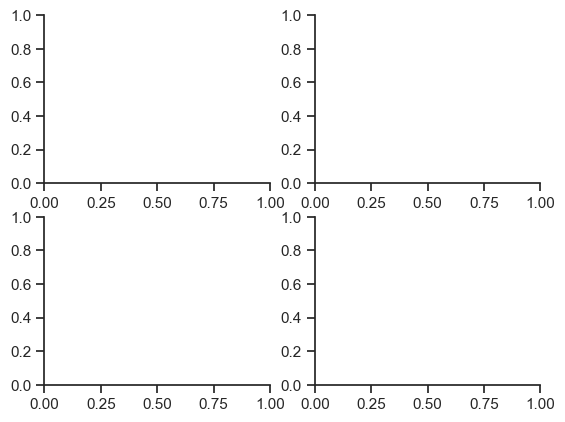

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"sh",3,1,'eval', smooth_factor=0.99, only_seeds=[1,2,4])
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sh",3,2,'eval', smooth_factor=0.5, flip_dict={1:[1,0,2],3:[1,0,2]})
ax3.set_title(" 2 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"sh",3,1,'eval', smooth_factor=0.99, only_seeds=[1,2,4], legend=["DCC", "CCC"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sh",3,2,'eval', smooth_factor=0.5, only_seeds=[5,2,4], legend=["DCC", "DCD"])
fig.suptitle("Stag Hunt, 3 players")
plt.savefig(path+"thesis/sh3_pl.pdf", bbox_inches='tight')
plt.show()



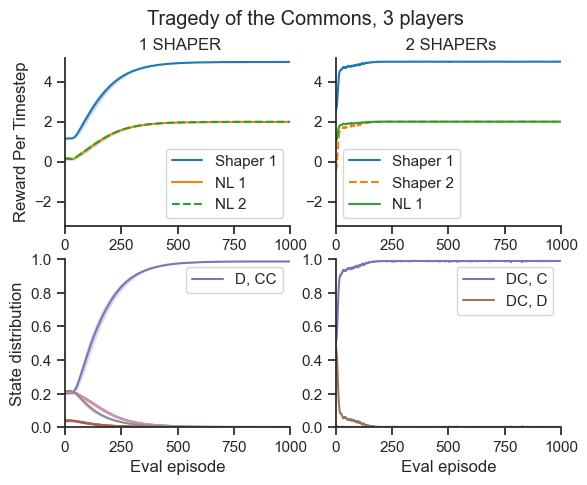

In [243]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"tc",3,1,'eval', smooth_factor=0.99,)
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"tc",3,2,'eval', smooth_factor=0.5, flip_dict={1:[1,0,2],3:[1,0,2]})
ax3.set_title(" 2 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"tc",3,1,'eval', smooth_factor=0.99, legend=["DCC"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"tc",3,2,'eval', smooth_factor=0.5, only_seeds=[5,2,4], legend=["DCC", "DCD"])
fig.suptitle("Tragedy of the Commons, 3 players")
plt.savefig(path+"thesis/tc3_pl.pdf", bbox_inches='tight')

plt.show()

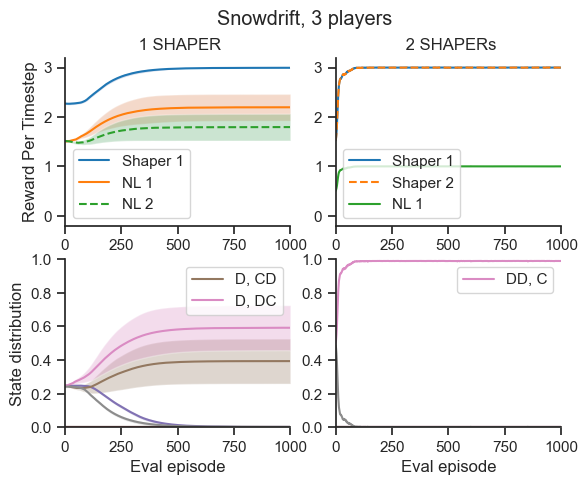

In [245]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"sd",3,1,'eval', smooth_factor=0.99,)
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sd",3,2,'eval', smooth_factor=0.5)
ax3.set_title(" 2 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"sd",3,1,'eval', smooth_factor=0.99, legend=["DDC", "DCD"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sd",3,2,'eval', smooth_factor=0.5, only_seeds=[5,2,4], legend=["DDC"])
fig.suptitle("Snowdrift, 3 players")
plt.savefig(path+"thesis/sd3_pl.pdf", bbox_inches='tight')

plt.show()

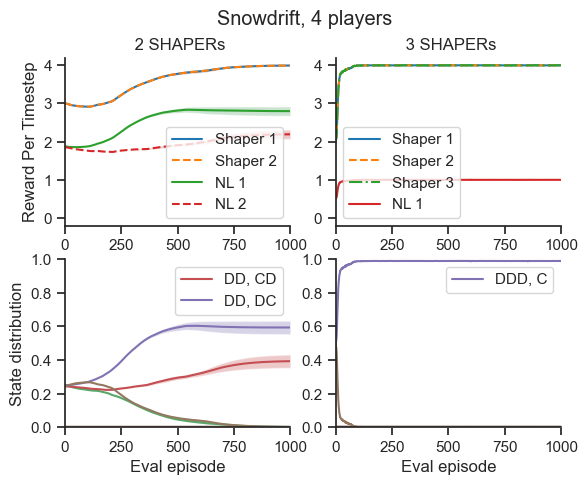

In [250]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"sd",4,2,'eval', smooth_factor=0.99,)
ax1.set_title(" 2 SHAPERs")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sd",4,3,'eval', smooth_factor=0.5)
ax3.set_title(" 3 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"sd",4,2,'eval', smooth_factor=0.99, legend=["DDCD", "DDDC"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sd",4,3,'eval', smooth_factor=0.5, only_seeds=[5,2,4], legend=["DDDC"])
fig.suptitle("Snowdrift, 4 players")
plt.savefig(path+"thesis/sd4_pl.pdf", bbox_inches='tight')

plt.show()

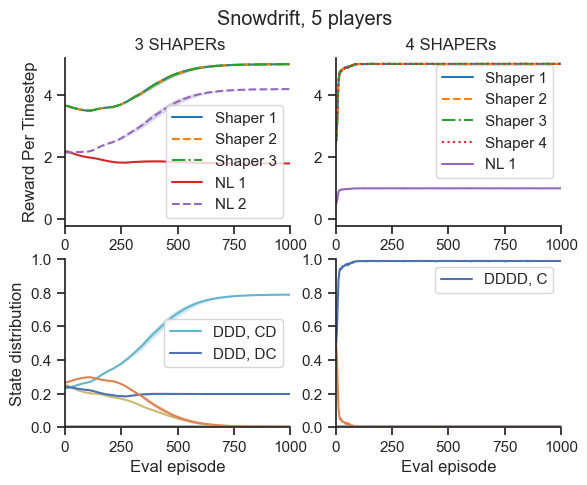

In [257]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"sd",5,3,'eval', smooth_factor=0.99,)
ax1.set_title(" 3 SHAPERs")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sd",5,4,'eval', smooth_factor=0.5)
ax3.set_title(" 4 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"sd",5,3,'eval', smooth_factor=0.99, legend=["DDDCD", "DDDDC"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sd",5,4,'eval', smooth_factor=0.5, only_seeds=[5,2,4], legend=["DDDDC"])
fig.suptitle("Snowdrift, 5 players")
plt.savefig(path+"thesis/sd5_pl.pdf", bbox_inches='tight')

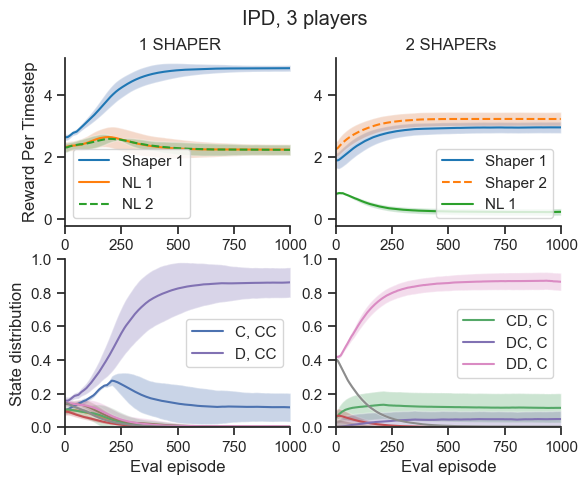

In [260]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"ipd",3,1,'eval', smooth_factor=0.99,)
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"ipd",3,2,'eval', smooth_factor=0.99)
ax3.set_title(" 2 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"ipd",3,1,'eval', smooth_factor=0.99, legend=["DCC", "CCC"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"ipd",3,2,'eval', smooth_factor=0.99, legend=["DDC", "DCC", "CDC"])
fig.suptitle("IPD, 3 players")
plt.savefig(path+"thesis/ipd3_pl.pdf", bbox_inches='tight')

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


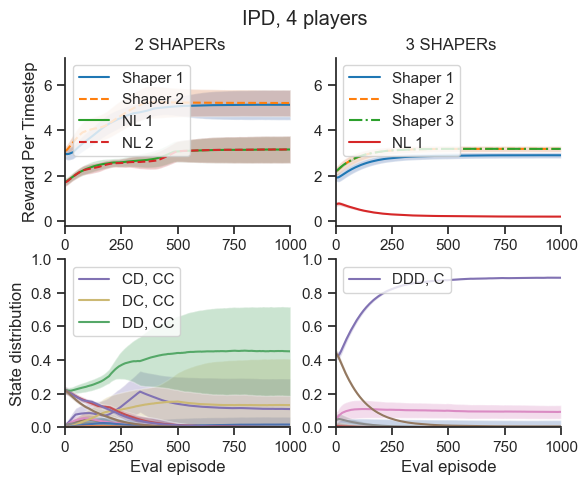

In [265]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"ipd",4,2,'eval', smooth_factor=0.99,)
ax1.set_title(" 2 SHAPERs")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"ipd",4,3,'eval', smooth_factor=0.99, only_seeds=[1,2,3,4], )
ax3.set_title(" 3 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"ipd",4,2,'eval', smooth_factor=0.99, legend=["DCCC","CDCC", "DDCC"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"ipd",4,3,'eval', smooth_factor=0.99, only_seeds=[1,2,3,4], legend=["DDDC"] )
fig.suptitle("IPD, 4 players")
plt.savefig(path+"thesis/ipd4_pl.pdf", bbox_inches='tight')

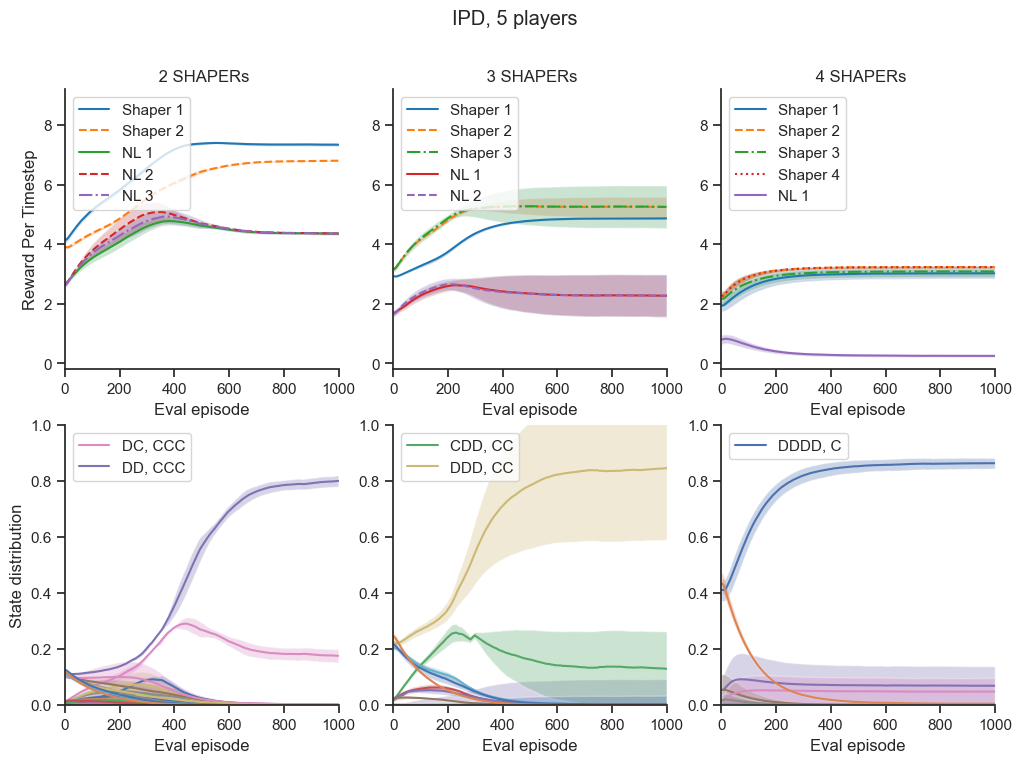

In [278]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,8))

ax1= plot_shaper_rewards(ax[0][0],"ipd",5,2,'eval', smooth_factor=0.99,)
ax1.set_title(" 2 SHAPERs")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"ipd",5,3,'eval', smooth_factor=0.99, )
ax3.set_title(" 3 SHAPERs")
ax5= plot_shaper_rewards(ax[0][2],"ipd",5,4,'eval', smooth_factor=0.99, )
ax5.set_title(" 4 SHAPERs")

ax2=plot_3pl_states(ax[1][0],"ipd",5,2,'eval', smooth_factor=0.99, legend=["DDCCC","DCCCC"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"ipd",5,3,'eval', smooth_factor=0.99, legend=["DDDCC", "CDDCC"] )
ax6=plot_3pl_states(ax[1][2],"ipd",5,4,'eval', smooth_factor=0.99, legend=["DDDDC"] )
fig.suptitle("IPD, 5 players")


plt.savefig(path+"thesis/ipd5_pl.pdf", bbox_inches='tight')

# Appendix plots

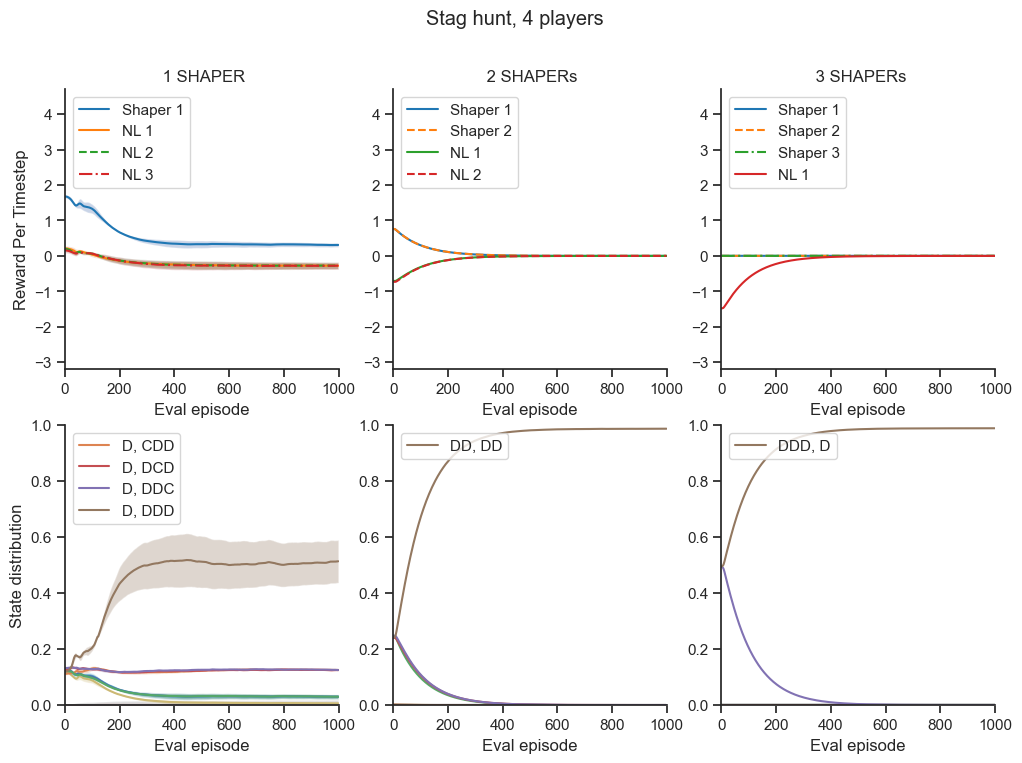

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,8))

ax1= plot_shaper_rewards(ax[0][0],"sh",4,1,'eval', smooth_factor=0.99,)
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sh",4,2,'eval', smooth_factor=0.99, )
ax3.set_title(" 2 SHAPERs")
ax5= plot_shaper_rewards(ax[0][2],"sh",4,3,'eval', smooth_factor=0.99, )
ax5.set_title(" 3 SHAPERs")

ax2=plot_3pl_states(ax[1][0],"sh",4,1,'eval', smooth_factor=0.99, legend=["DDDD", "DDDC", "DDCD", "DCDD"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sh",4,2,'eval', smooth_factor=0.99, legend=["DDDD"] )
ax6=plot_3pl_states(ax[1][2],"sh",4,3,'eval', smooth_factor=0.99, legend=["DDDD"] )
fig.suptitle("Stag hunt, 4 players")


plt.savefig(path+"thesis/sh4_pl.pdf", bbox_inches='tight')


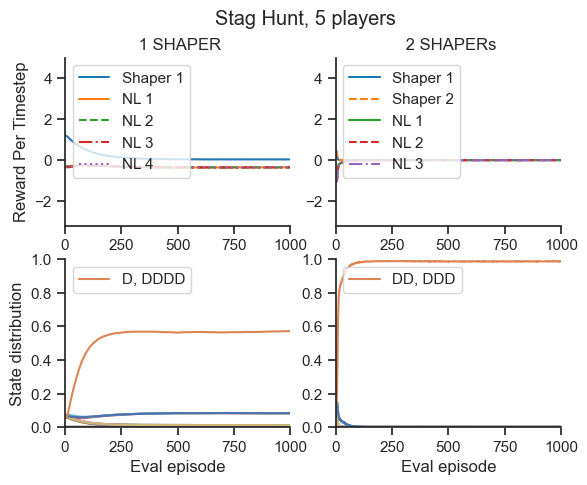

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"sh",5,1,'eval', smooth_factor=0.99,)
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sh",5,2,'eval', smooth_factor=0.5, )
ax3.set_title(" 2 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"sh",5,1,'eval', smooth_factor=0.99,legend=["DDDDD"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sh",5,2,'eval', smooth_factor=0.5, only_seeds=[5,2,4], legend=["DDDDD"])
fig.suptitle("Stag Hunt, 5 players")
plt.savefig(path+"thesis/sh5_pl1.pdf", bbox_inches='tight')
plt.show()

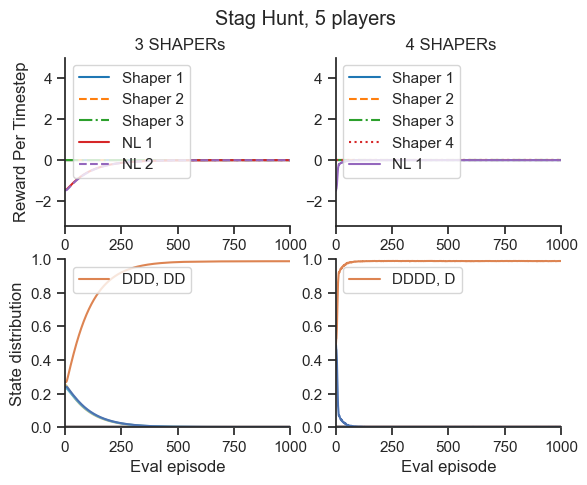

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, )

ax1= plot_shaper_rewards(ax[0][0],"sh",5,3,'eval', smooth_factor=0.99,)
ax1.set_title(" 3 SHAPERs")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sh",5,4,'eval', smooth_factor=0.5, )
ax3.set_title(" 4 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"sh",5,3,'eval', smooth_factor=0.99,legend=["DDDDD"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sh",5,4,'eval', smooth_factor=0.5, legend=["DDDDD"])
fig.suptitle("Stag Hunt, 5 players")
plt.savefig(path+"thesis/sh5_pl2.pdf", bbox_inches='tight')
plt.show()

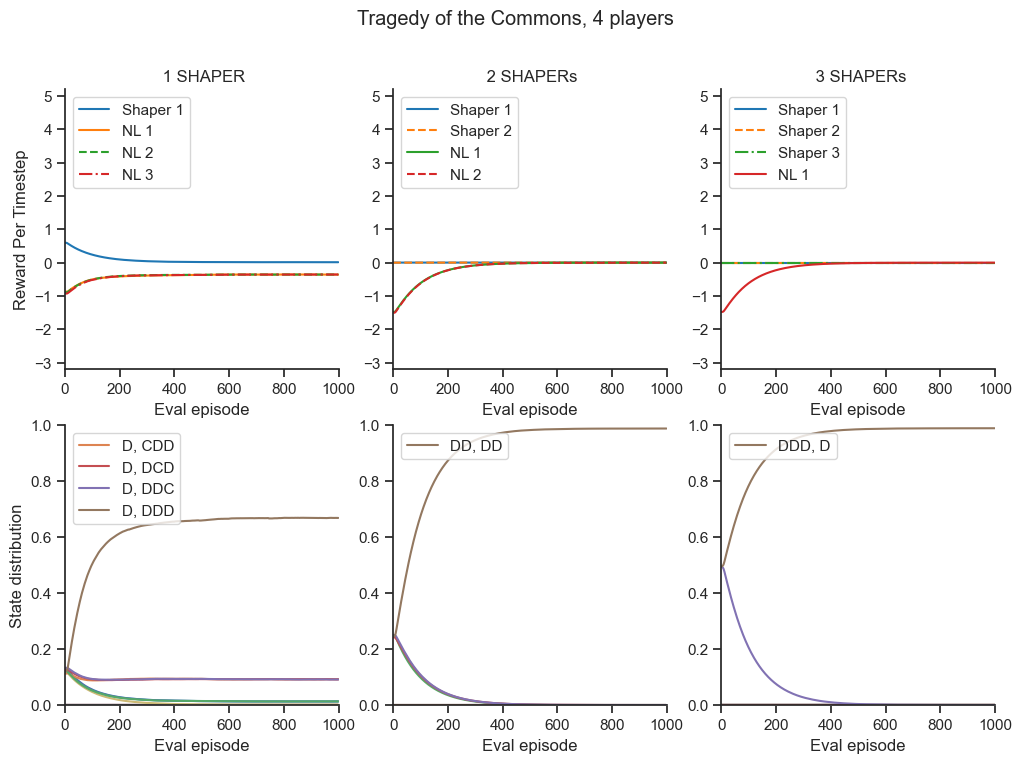

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,8))

ax1= plot_shaper_rewards(ax[0][0],"tc",4,1,'eval', only_seeds=[1,2,4,5], smooth_factor=0.99,)
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"tc",4,2,'eval', smooth_factor=0.99, )
ax3.set_title(" 2 SHAPERs")
ax5= plot_shaper_rewards(ax[0][2],"tc",4,3,'eval', smooth_factor=0.99, )
ax5.set_title(" 3 SHAPERs")

ax2=plot_3pl_states(ax[1][0],"tc",4,1,'eval', smooth_factor=0.99, only_seeds=[1,2,4,5],legend=["DDDD", "DDDC", "DDCD", "DCDD"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"tc",4,2,'eval', smooth_factor=0.99, legend=["DDDD"] )
ax6=plot_3pl_states(ax[1][2],"tc",4,3,'eval', smooth_factor=0.99, legend=["DDDD"] )
fig.suptitle("Tragedy of the Commons, 4 players")


plt.savefig(path+"thesis/tc4_pl.pdf", bbox_inches='tight')

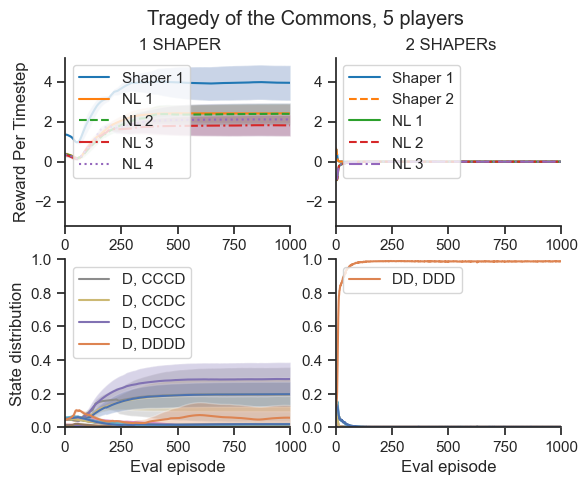

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"tc",5,1,'eval', smooth_factor=0.99,)
ax1.set_title(" 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"tc",5,2,'eval', smooth_factor=0.5, )
ax3.set_title(" 2 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"tc",5,1,'eval', smooth_factor=0.99,legend=["DDDDD", "DDCCC", "DCCDC", "DCCCD",])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"tc",5,2,'eval', smooth_factor=0.5, only_seeds=[5,2,4], legend=["DDDDD"])
fig.suptitle("Tragedy of the Commons, 5 players")
plt.savefig(path+"thesis/tc5_pl1.pdf", bbox_inches='tight')
plt.show()

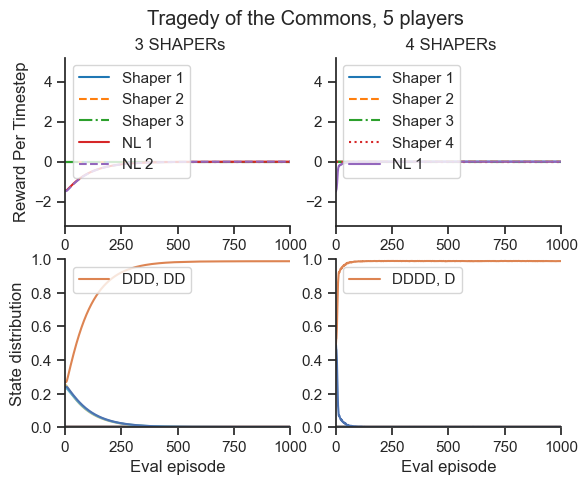

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"tc",5,3,'eval', smooth_factor=0.99,)
ax1.set_title(" 3 SHAPERs")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"tc",5,4,'eval', smooth_factor=0.5, )
ax3.set_title(" 4 SHAPERs")
ax2=plot_3pl_states(ax[1][0],"tc",5,3,'eval', smooth_factor=0.99,legend=["DDDDD"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"tc",5,4,'eval', smooth_factor=0.5, legend=["DDDDD"])
fig.suptitle("Tragedy of the Commons, 5 players")
plt.savefig(path+"thesis/tc5_pl2.pdf", bbox_inches='tight')
plt.show()

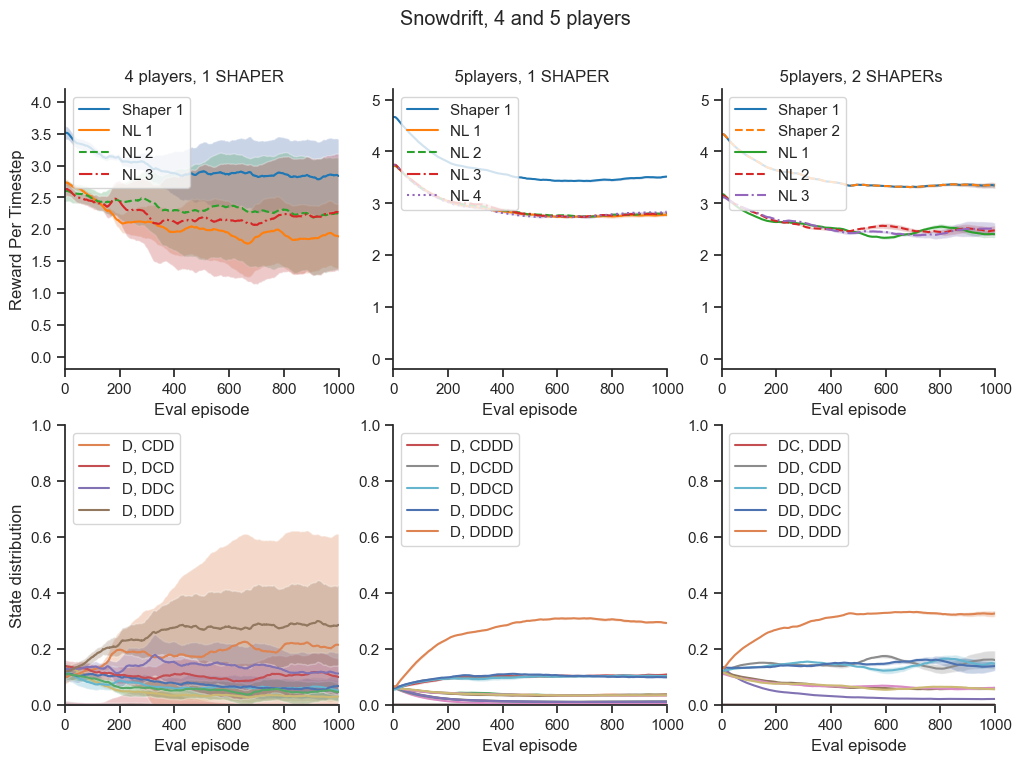

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(12,8))

ax1= plot_shaper_rewards(ax[0][0],"sd",4,1,'eval', smooth_factor=0.99,)
ax1.set_title(" 4 players, 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"sd",5,1,'eval', smooth_factor=0.99, )
ax3.set_title(" 5players, 1 SHAPER")
ax5= plot_shaper_rewards(ax[0][2],"sd",5,2,'eval', smooth_factor=0.99, )
ax5.set_title(" 5players, 2 SHAPERs")

ax2=plot_3pl_states(ax[1][0],"sd",4,1,'eval', smooth_factor=0.99, legend=["DCDD", "DDCD", "DDDC", "DDDD"])
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"sd",5,1,'eval', smooth_factor=0.99, legend=["DDDDD", "DCDDD", "DDCDD", "DDDCD", "DDDDC"] )
ax6=plot_3pl_states(ax[1][2],"sd",5,2,'eval', smooth_factor=0.99, legend=["DDDDD", "DCDDD", "DDCDD", "DDDCD", "DDDDC"] )
fig.suptitle("Snowdrift, 4 and 5 players")


plt.savefig(path+"thesis/sd45_pl.pdf", bbox_inches='tight')

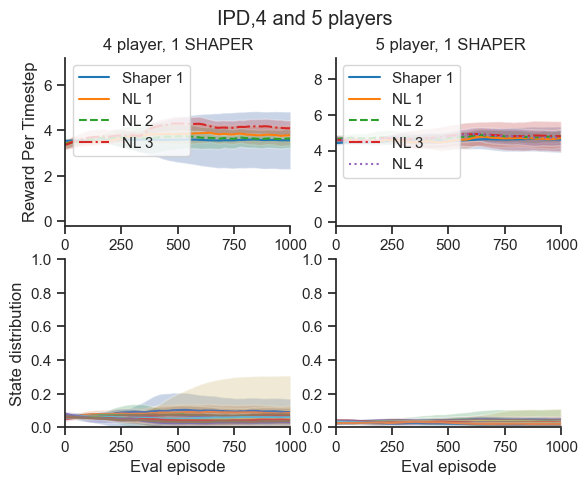

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax1= plot_shaper_rewards(ax[0][0],"ipd",4,1,'eval', smooth_factor=0.99,)
ax1.set_title("4 player, 1 SHAPER")
ax1.set_ylabel("Reward Per Timestep")
ax3= plot_shaper_rewards(ax[0][1],"ipd",5,1,'eval', smooth_factor=0.99, )
ax3.set_title(" 5 player, 1 SHAPER")
ax2=plot_3pl_states(ax[1][0],"ipd",4,1,'eval', smooth_factor=0.99,)
ax2.get_legend().remove()
ax2.set_ylabel("State distribution")
ax4=plot_3pl_states(ax[1][1],"ipd",5,1,'eval', smooth_factor=0.99,)
ax4.get_legend().remove()
fig.suptitle("IPD,4 and 5 players")
plt.savefig(path+"thesis/ipd45_pl2.pdf", bbox_inches='tight')
plt.show()